# Progetto di Architetture Dati - Pulerà Francesca e Zarantonello Massimo


## Introduzione

L'obiettivo del seguente progetto è costruire un modello di **classificazione dei Punti di Interesse (POI)**, al fine di assegnare a ciascun POI una categoria corretta (ad esempio, museo, ristorante, parco, negozio). Partendo da un dataset estratto da OpenStreetMap, il nostro scopo è analizzare come le **problematiche di qualità dei dati**, come dati mancanti, errori ortografici, e incoerenze, possano influenzare l'efficacia dei modelli di machine learning (ML).

In particolare, vogliamo esplorare il principio del **"garbage in, garbage out"**: ovvero, come la qualità dei dati in ingresso influisca direttamente sulle prestazioni del modello. A tal fine, confrontiamo i risultati ottenuti utilizzando versioni del dataset con vari livelli di qualità dei dati (completi, incompleti, errati e inconsistenti), per osservare l'impatto su metriche di performance come **accuracy**, **precision**, **recall**, e **F1-score**.

I passaggi principali di questo progetto comprendono:
1. **Estrazione dei dati** da OpenStreetMap tramite Overpass API.
2. **Pulizia dei dati**: gestione dei valori mancanti, correzione degli errori ortografici e gestione delle incoerenze nei dati.
3. **Creazione di versioni del dataset** per testare l'impatto della qualità dei dati: versioni "pulite", "sporche" (con errori e dati mancanti), e "inconsistenti".
4. **Costruzione e validazione dei modelli** di classificazione sui diversi dataset, comparando le performance.
5. **Conclusioni** e raccomandazioni per il miglioramento continuo della qualità dei dati.

Il nostro approccio mira a mostrare chiaramente come un processo di data cleaning ben eseguito possa migliorare significativamente le prestazioni dei modelli di machine learning e come la qualità dei dati dovrebbe essere un aspetto fondamentale nella costruzione di qualsiasi sistema predittivo.





### Scelta di OpenStreetMap come fonte di dati

La scelta di **OpenStreetMap (OSM)** come fonte principale per l'estrazione dei dati sui Punti di Interesse (POI) è stata motivata da diverse considerazioni pratiche e metodologiche:

1. **Accesso aperto e gratuito ai dati**: OpenStreetMap è un progetto open-source che fornisce dati geospaziali altamente dettagliati e aggiornati, utili per una vasta gamma di applicazioni. Non richiede costosi abbonamenti né licenze commerciali, offrendo una risorsa gratuita e facilmente accessibile.
  
2. **Diversità di dati**: OSM include una grande varietà di informazioni sui POI, suddivisi in diverse categorie come **amenities**, **tourism**, e **shop**, che sono essenziali per la nostra attività di classificazione. La possibilità di estrarre informazioni dettagliate su luoghi e attività ci ha permesso di progettare un modello in grado di discriminare tra vari tipi di POI in base alle loro caratteristiche geografiche e tematiche.

3. **Comunità e aggiornamenti continui**: la comunità di contributori di OSM è vasta e attiva, il che garantisce aggiornamenti continui dei dati. Questo è un aspetto cruciale per il nostro progetto, in quanto ci permette di lavorare con dati che riflettono costantemente il cambiamento del panorama urbano e del turismo a livello globale.

4. **Flessibilità e disponibilità tramite API**: OpenStreetMap offre interfacce di accesso facili da utilizzare come **Overpass API**, che ci ha consentito di estrarre dati in modo mirato e flessibile, filtrando i POI in base alle nostre necessità (es. POI turistici, ristoranti, ecc.) e velocizzando così la raccolta dei dati necessari per il nostro progetto.


### Applicazioni pratiche nel mondo reale

Le applicazioni di un modello come il nostro sono numerose e variano in diversi settori. Ecco alcune possibili applicazioni nel mondo reale:

1. **Turismo e navigazione intelligente**: con una classificazione accurata dei POI, le applicazioni turistiche e di navigazione potrebbero suggerire in modo intelligente luoghi di interesse personalizzati in base alla geolocalizzazione e alle preferenze dell'utente.

2. **Pianificazione urbana nelle smart cities**: il modello potrebbe essere utilizzato dalle amministrazioni locali per pianificare meglio l'infrastruttura urbana, comprendere la distribuzione dei servizi (ospedali, scuole, trasporti) e ottimizzare la mobilità.

3. **Marketing e targeting pubblicitario**: le aziende potrebbero utilizzare questo modello per segmentare il mercato e indirizzare le campagne pubblicitarie in base alla tipologia di POI (ad esempio, pubblicità per i negozi vicino a musei o parchi).

4. **Settore della salute**: una corretta classificazione dei POI potrebbe essere utilizzata per mappare punti di interesse legati alla salute, come ospedali, cliniche, farmacie, utili per migliorare la pianificazione dei servizi sanitari.

5. **Applicazioni sociali e per il sociale**: la categorizzazione dei POI in base alla loro accessibilità può risultare utile per garantire che spazi pubblici, trasporti e strutture siano accessibili a tutte le persone, inclusi anziani e persone con disabilità.

In sostanza, il nostro progetto non si limita a essere un'esercitazione accademica, ma potrebbe avere applicazioni pratiche utili, come supportare la pianificazione urbana, migliorare la gestione delle risorse pubbliche, o ottimizzare strategie di marketing basate sulla geolocalizzazione.

In [ ]:
# importazioni
import json
from collections import Counter
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import spacy # type: ignore
from scipy.stats import chi2_contingency # type: ignore
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore
from sklearn.preprocessing import OneHotEncoder # type: ignore
import numpy as np # type: ignore
from sklearn.preprocessing import LabelEncoder # type: ignore
from scipy.sparse import hstack # type: ignore
from scipy.sparse import csr_matrix # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.svm import SVC # type: ignore
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix # type: ignore
from fuzzywuzzy import fuzz # type: ignore
import unicodedata
import string
from sklearn.tree import DecisionTreeClassifier # type: ignore
from sklearn.metrics import accuracy_score, classification_report # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from sklearn.metrics import accuracy_score, classification_report # type: ignore
import seaborn as sns # type: ignore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # type: ignore


## Funzioni utili

In questa sezione sono presenti alcune funzioni utili al fine del progetto.

In [3]:
# Funzione che rimuove l'intestazione da un file GeoJSON
def remove_geojson_header(input_file, output_file):
    # Leggiamo il contenuto del file GeoJSON
    with open(input_file, 'r', encoding='utf-8') as infile:
        geojson_data = json.load(infile)
        
    # Estraiamo solo la parte 'features' dal GeoJSON
    cleaned_data = {
        "features": geojson_data.get("features", [])
    }
    
    # Scriviamo il nuovo file JSON (senza intestazione)
    with open(output_file, 'w', encoding='utf-8') as outfile:
        json.dump(cleaned_data, outfile, ensure_ascii=False, indent=2)

In [4]:
# Definiamo la funzione che unifica le etichette
def get_target(row):
    # Controlliamo se tutte e tre le colonne sono 'other'
    if row['amenity_label'] == 'other' and row['tourism_label'] == 'other' and row['shop_label'] == 'other':
        return 'other'
    # Se almeno una delle etichette è diversa da 'other', prendiamo la prima etichetta non 'other'
    labels = [row['amenity_label'], row['tourism_label'], row['shop_label']]
    for label in labels:
        if label != 'other':
            return label
    # Caso di fallback nel caso tutte siano 'other'
    return 'other'

In [5]:
def normalize_text(text):
    if isinstance(text, str):
        return unicodedata.normalize('NFKC', text)  # Normalizza Unicode
    return text

In [6]:
# Funzione per pulire descrizioni
def pulisci_descrizione(descrizione, file):
    for errato, corretto in file.items():
        descrizione = descrizione.replace(errato, corretto)
    return descrizione

In [7]:
# Carichiamo il modello italiano
tokenizer = spacy.load('it_core_news_sm')

In [8]:
# Funzione di preprocessing
def preprocess_text(text):
    # Controlla se il testo non è vuoto o NaN
    if pd.isna(text):
        return ""
    # Tokenizza il testo e applica il preprocessing
    doc = tokenizer(text.lower())  # Converte in minuscolo
    tokens = [
        token.lemma_  # Lemmatizzazione
        for token in doc
        if not token.is_stop  # Esclude stop words
        and not token.is_punct  # Esclude la punteggiatura
        and not token.like_num  # Esclude i numeri
    ]
    return " ".join(tokens)

In [9]:
def save_time_stamp(text, start, end):
    round_end = round(end - start, 3)
    with open("time_stamp.txt", "a") as f:
        f.write(f"{text} - Durata: {round_end} secondi\n")

## Qual è il problema che vogliamo risolvere? 
**CLASSIFICAZIONE**: identificare il tipo di punto di interesse (POI) dato un insieme di caratteristiche.


Con la seguente query abbiamo estratto tramite OverpassTurbo tutti i POI (Point of Interest) italiani relativi ai tag (propri di OpenStreetMap) "**amenity**", che classifica i POI per funzione (es. restaurant, hospital, school), "**shop**", utile per classificare negozi (es. supermarket, bakery) e "**tourism**", le attrazioni turistiche (es. museum, hotel, viewpoint):

```json
[out:json];
(
  node["description:it"]["amenity"](35.4897,6.6267,47.0920,18.5204);
  node["description:it"]["shop"](35.4897,6.6267,47.0920,18.5204);
  node["description:it"]["tourism"](35.4897,6.6267,47.0920,18.5204);
);
out;
```

In [10]:
# Carichiamo il file GeoJSON
with open('exports.geojson', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [11]:
# Dimensione del dataset
print("Numero di elementi: ", len(data['features']))

Numero di elementi:  2677


Abbiamo quindi estratto un totale di **2677 POI italiani**.

Ora procediamo con l'**esplorazione dei dati**.

## Esplorazione, Preparazione e Pulizia dei dati

Per migliorare la qualità del nostro dataset e garantire analisi accurate e significative, è essenziale adottare un approccio sistematico alla pulizia dei dati. Questo processo ci permette di eliminare errori, anomalie e incongruenze che potrebbero compromettere la validità dei risultati. La **pulizia dei dati** non è solo un passaggio preparatorio, ma una fase fondamentale per valorizzare e sfruttare appieno le potenzialità dei nostri dati.


Durante la prima fase di esplorazione, ci concentreremo sui seguenti punti principali:

* **Distribuzione delle feature principali**: esamineremo le categorie principali (amenity, tourism, ecc.) per comprendere meglio la composizione del dataset.
* **Definizione delle etichette**: analizzeremo i dati per stabilire criteri chiari e coerenti per l’etichettatura del dataset.
* **Valutazione della qualità dei dati**: identificheremo eventuali problemi, come dati mancanti, duplicati o incoerenti, che potrebbero compromettere le prestazioni dei modelli.
* **Analisi della struttura del dataset**: esamineremo le caratteristiche (properties) dei POI per valutarne la rilevanza e l’utilità nel processo di classificazione.
Questa analisi ci aiuterà a identificare possibili criticità e a implementare interventi di **data cleaning**, preparando un dataset etichettato che potrà essere utilizzato efficacemente nella pipeline di classificazione.

### Distribuzione delle feature principali

Come prima cosa cerchiamo di capire quanti POI abbiamo sotto ciascuna categoria estratta, per poter decidere con quale criterio etichettarli.

In [12]:
# Estraiamo gli amenity da tutti i POI (se presenti)
amenities = [feature['properties']['amenity'] for feature in data['features'] if 'amenity' in feature['properties']]

# Estraiamo gli shop da tutti i POI (se presenti)
shops = [feature['properties']['shop'] for feature in data['features'] if 'shop' in feature['properties']]

# Estraiamo i tourism da tutti i POI (se presenti)
tourisms = [feature['properties']['tourism'] for feature in data['features'] if 'tourism' in feature['properties']]

# Contiamo la frequenza di ciascun amenity
amenity_counts = Counter(amenities)

# Contiamo la frequenza di ciascun shop
shop_counts = Counter(shops)

# Contiamo la frequenza di ciascun tourism
tourism_counts = Counter(tourisms)

# Ordiniamo gli amenity per numeri di occorrenze (in ordine decrescente)
sorted_amenities = amenity_counts.most_common()

# Ordiniamo gli shop per numeri di occorrenze (in ordine decrescente)
sorted_shops = shop_counts.most_common()

# Ordiniamo i tourism per numeri di occorrenze (in ordine decrescente)
sorted_tourisms = tourism_counts.most_common()

In [13]:
# Stampiamo i risultati di amenity
print("Numero totale di amenity: ", len(amenities), "\n")
for amenity, count in sorted_amenities:
    print(f"{amenity}: {count}")

Numero totale di amenity:  781 

pharmacy: 212
drinking_water: 100
restaurant: 85
social_facility: 53
fountain: 38
cafe: 32
shelter: 27
fast_food: 25
ticket_validator: 22
vending_machine: 21
school: 18
lavoir: 17
bar: 16
ice_cream: 14
recycling: 6
bench: 6
pub: 5
kindergarten: 5
toilets: 5
library: 4
bicycle_rental: 4
police: 4
waste_basket: 4
parking: 3
place_of_worship: 3
dentist: 3
charging_station: 3
watering_place: 3
fuel: 2
doctors: 2
bicycle_parking: 2
bicycle_repair_station: 2
arts_centre: 2
marketplace: 2
clinic: 2
cinema: 1
bell: 1
clock: 1
university: 1
crypt: 1
car_wash: 1
convenience: 1
education: 1
taxi: 1
post_office: 1
mortuary: 1
animal_shelter: 1
driving_school: 1
waste_disposal: 1
public_bath: 1
archive: 1
deli: 1
public_bookcase: 1
give_box: 1
social_centre: 1
copystamp: 1
atm: 1
bank: 1
parcel_locker: 1
bbq: 1
place_of_mourning: 1
water_point: 1
crematorium: 1
nursing_home: 1


Il numero totale di amenity è 781, con una forte prevalenza di categorie come pharmacy, drinking_water e restaurant.

In [14]:
# Stampiamo i risultati di shop
print("Numero totale di shop: ", len(shops), "\n")
for shop, count in sorted_shops:
    print(f"{shop}: {count}")

Numero totale di shop:  442 

deli: 44
farm: 36
convenience: 33
pastry: 19
wine: 17
butcher: 16
bakery: 14
greengrocer: 13
stationery: 13
clothes: 10
laundry: 9
florist: 8
hardware: 8
pasta: 7
houseware: 6
tobacco: 6
hairdresser: 5
supermarket: 5
books: 5
newsagent: 5
chemist: 5
ticket: 5
copyshop: 5
yes: 4
shoes: 4
car_repair: 4
computer: 4
furniture: 4
optician: 4
bicycle: 3
sports: 3
jewelry: 3
confectionery: 3
dairy: 3
car_parts: 3
hairdresser_supply: 3
kiosk: 3
gift: 3
coffee: 3
fabric: 3
nutrition_supplements: 3
tyres: 2
perfumery: 2
frame: 2
alcohol: 2
herbalist: 2
mobile_phone_accessories: 2
appliance: 2
electronics: 2
music: 2
baby_goods: 2
outdoor: 2
toys: 2
security: 2
flooring: 2
interior_decoration: 2
art: 2
doors: 2
pet: 2
rental: 2
garden_centre: 2
beverages: 2
fashion_accessories: 1
fair_trade: 1
cheese: 1
plumbing: 1
lighting: 1
knives: 1
tailor: 1
radiotechnics: 1
motorcycle: 1
religion: 1
safety: 1
stone: 1
3d_printing: 1
electrical: 1
mechanical_parts: 1
craft: 1
se

Osservando i dati relativi alla categoria shop, emerge una significativa presenza di categorie legate al cibo e alla gastronomia, come deli, farm, convenience, pastry, wine, butcher, bakery, e greengrocer. Queste categorie rappresentano attività strettamente collegate e potrebbero essere accorpate sotto una macro-categoria più ampia, ad esempio "food_retail", per rendere il dataset più omogeneo e facilitare il processo di classificazione.

In [15]:
# Stampiamo i risultati di tourism
print("Numero totale di tourism: ", len(tourisms), "\n")
for tourism, count in sorted_tourisms:
    print(f"{tourism}: {count}")

Numero totale di tourism:  1543 

information: 1326
attraction: 72
artwork: 40
guest_house: 35
viewpoint: 23
museum: 14
apartment: 13
hotel: 11
alpine_hut: 3
giant_furniture: 2
chalet: 1
picnic_site: 1
hostel: 1
camp_pitch: 1


I dati relativi al turismo mostrano un'evidente predominanza della categoria information, con 1326 occorrenze su un totale di 1543. Tuttavia, risulta opportuno considerare anche la categoria attraction, che con 72 occorrenze rappresenta una componente significativa all'interno del contesto turistico.

In [16]:
# Specifichiamo il percorso del file di input (GeoJSON) e del file di output (JSON)
input_file = 'exports.geojson'  
output_file = 'pois.json'               

# Rimuoviamo l'intestazione e salviamo il nuovo file JSON
remove_geojson_header(input_file, output_file)

print(f"Il file JSON senza intestazione è stato salvato come '{output_file}'")

Il file JSON senza intestazione è stato salvato come 'pois.json'


### Definizione delle etichette

Lo scopo di questa parte della pipeline è creare un **dataset etichettato** basato sulle label di OSM, come ad esempio amenity, tourism, leisure e shop, in modo da disporre di una base solida per il training dei modelli di machine learning. Le etichette ci permetteranno di costruire un modello che non solo può classificare con precisione i punti di interesse (POI) esistenti, ma che sarà anche in grado di gestire e categorizzare nuovi dati che verranno raccolti in futuro.

In [17]:
# Carichiamo i dati JSON in un DataFrame
with open('pois.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Estraiamo le informazioni rilevanti (properties) per creare un DataFrame
data_properties = [feature['properties'] for feature in data['features']]
df = pd.DataFrame(data_properties)

# Mostriamo le prime righe del DataFrame
df.head()

,@id,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,check_date,description:it,dispensing,drive_through,...,contact:foursquare,contact:spotify,charging_station:type,crematorium,alt_name:it,online_shopping,fax_1,service_times,brand:website,armrest
0,node/254087448,Pescara,20-23,65123,Piazza San Francesco d'Assisi,pharmacy,2020-12-05,orari attuale e turno sul sito web,yes,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/254087764,Montesilvano,22-23/d2,65015,Via Europa,pharmacy,2020-12-06,orarfi attuale e turni sul sito web,yes,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/298376518,NaN,NaN,NaN,Corso Italia,cafe,NaN,"Più di una semplice caffetteria, rappresenta u...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/302324772,NaN,NaN,NaN,NaN,cinema,NaN,"Proiezioni cinematografiche, spettacoli teatra...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/302369315,NaN,NaN,NaN,NaN,NaN,NaN,Vista sulla citta' di Genova ed aree circostanti,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.shape

(2677, 504)

In [19]:
# Esploriamo la distribuzione delle classi nel campo 'amenity'
print("Distribuzione delle classi nel campo 'amenity':")
print(df['amenity'].value_counts())

Distribuzione delle classi nel campo 'amenity':
amenity
pharmacy           212
drinking_water     100
restaurant          85
social_facility     53
fountain            38
                  ... 
university           1
clock                1
bell                 1
cinema               1
nursing_home         1
Name: count, Length: 64, dtype: int64


Per la categoria amenity, decidiamo di mantenere come etichette principali pharmacy, drinking_water e restaurant, che sono le più frequenti. Tutte le altre categorie, caratterizzate da poche occorrenze, verranno raggruppate sotto l'etichetta "other". Questa scelta semplifica il modello, migliora la generalizzazione e riduce il rischio di squilibri dovuti a classi poco rappresentate.

In [20]:
# Definiamo le etichette da mantenere
categories_to_keep = ['pharmacy', 'drinking_water', 'restaurant']

# Creiamo una nuova colonna con l'etichetta modificata
df['amenity_label'] = df['amenity'].apply(lambda x: x if x in categories_to_keep else 'other')

# Eliminiamo la colonna 'amenity'
df = df.drop(columns=['amenity'])

# Controlliamo la distribuzione delle nuove etichette
print("Distribuzione delle classi nel campo 'amenity_label':")
print(df['amenity_label'].value_counts())

Distribuzione delle classi nel campo 'amenity_label':
amenity_label
other             2280
pharmacy           212
drinking_water     100
restaurant          85
Name: count, dtype: int64


In [21]:
# Esploriamo la distribuzione delle classi nel campo 'shop'
print("Distribuzione delle classi nel campo 'shop':")
print(df['shop'].value_counts())

Distribuzione delle classi nel campo 'shop':
shop
deli           44
farm           36
convenience    33
pastry         19
wine           17
               ..
cosmetics       1
hvac            1
motorcycle      1
flour           1
fair_trade      1
Name: count, Length: 108, dtype: int64


Abbiamo deciso di unificare le categorie di negozi alimentari e simili sotto un'unica etichetta '**food**' per semplificare la classificazione, riducendo il numero di categorie e creando un modello più gestibile. Le restanti categorie di negozi, meno frequenti, sono state classificate come 'other' per evitare un numero eccessivo di etichette, mantenendo un equilibrio tra complessità e interpretabilità del modello.

In [22]:
# Definiamo le categorie alimentari che vogliamo unificare come "food"
food_categories = ['deli', 'farm', 'convenience', 'pastry', 'wine', 'butcher', 'bakery', 'greengrocer', 'stationery', 'clothes']

# Creiamo la colonna 'shop_label' che classifica i negozi alimentari come "food" e tutte le altre come "other"
df['shop_label'] = df['shop'].apply(lambda x: 'food' if x in food_categories else 'other')

# Verifichiamo della distribuzione delle etichette
print(df['shop_label'].value_counts())

# Eliminiamo la colonna 'shop'
df = df.drop(columns=['shop'])

shop_label
other    2462
food      215
Name: count, dtype: int64


In [23]:
# Esploriamo la distribuzione delle classi nel campo 'tourism'
print("Distribuzione delle classi nel campo 'tourism':")
print(df['tourism'].value_counts())

Distribuzione delle classi nel campo 'tourism':
tourism
information        1326
attraction           72
artwork              40
guest_house          35
viewpoint            23
museum               14
apartment            13
hotel                11
alpine_hut            3
giant_furniture       2
chalet                1
picnic_site           1
hostel                1
camp_pitch            1
Name: count, dtype: int64


Poiché la categoria "information" domina la distribuzione dei dati e la categoria "attraction" rappresenta una buona seconda scelta con un numero significativo di occorrenze, decidiamo di mantenerle. Tutte le altre categorie saranno classificate come "other" per evitare una frammentazione inutile del dataset e migliorare la robustezza del modello di classificazione.



In [24]:
# Definiamo le categorie principali da mantenere
categories_to_keep = ['information', 'attraction']

# Creiamo una nuova colonna con l'etichetta modificata per il campo tourism
df['tourism_label'] = df['tourism'].apply(lambda x: x if x in categories_to_keep else 'other')

# Controlliamo la distribuzione delle nuove etichette
print("Distribuzione delle classi nel campo 'tourism_label':")
print(df['tourism_label'].value_counts())

# Eliminiamo la colonna 'tourism'
df = df.drop(columns=['tourism'])

Distribuzione delle classi nel campo 'tourism_label':
tourism_label
information    1326
other          1279
attraction       72
Name: count, dtype: int64


In [25]:
df.head()

,@id,addr:city,addr:housenumber,addr:postcode,addr:street,check_date,description:it,dispensing,drive_through,healthcare,...,crematorium,alt_name:it,online_shopping,fax_1,service_times,brand:website,armrest,amenity_label,shop_label,tourism_label
0,node/254087448,Pescara,20-23,65123,Piazza San Francesco d'Assisi,2020-12-05,orari attuale e turno sul sito web,yes,no,pharmacy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pharmacy,other,other
1,node/254087764,Montesilvano,22-23/d2,65015,Via Europa,2020-12-06,orarfi attuale e turni sul sito web,yes,no,pharmacy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pharmacy,other,other
2,node/298376518,NaN,NaN,NaN,Corso Italia,NaN,"Più di una semplice caffetteria, rappresenta u...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other,other,other
3,node/302324772,NaN,NaN,NaN,NaN,NaN,"Proiezioni cinematografiche, spettacoli teatra...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other,other,other
4,node/302369315,NaN,NaN,NaN,NaN,NaN,Vista sulla citta' di Genova ed aree circostanti,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other,other,other


A questo punto, abbiamo tre colonne separate, ciascuna contenente etichette per categorie diverse, che desideriamo combinare in una sola colonna chiamata "target". Se in tutte e tre le colonne è presente l'etichetta "other", la colonna "target" riceverà il valore "other". In questo modo, creiamo un'unica colonna che rappresenta la classificazione finale per ciascuna riga, semplificando l'analisi e l'uso delle etichette.

In [26]:
# Applicare la funzione a ogni riga del dataframe
df['target'] = df.apply(get_target, axis=1)

# Mostriamo il risultato
print(df[['amenity_label', 'tourism_label', 'shop_label', 'target']].head())


  amenity_label tourism_label shop_label    target
0      pharmacy         other      other  pharmacy
1      pharmacy         other      other  pharmacy
2         other         other      other     other
3         other         other      other     other
4         other         other      other     other


In [27]:
# Eliminiamo le colonne 'amenity_label', 'tourism_label' e 'shop_label'
df = df.drop(columns=['amenity_label', 'tourism_label', 'shop_label'])

In [28]:
# Verifichiamo le classi della colonna 'target'
print("Distribuzione delle classi nel campo 'target':")
print(df['target'].value_counts())

Distribuzione delle classi nel campo 'target':
target
information       1326
other              676
pharmacy           212
food               209
drinking_water     100
restaurant          85
attraction          69
Name: count, dtype: int64


In [29]:
df['target'].value_counts().keys()

Index(['information', 'other', 'pharmacy', 'food', 'drinking_water',
       'restaurant', 'attraction'],
      dtype='object', name='target')

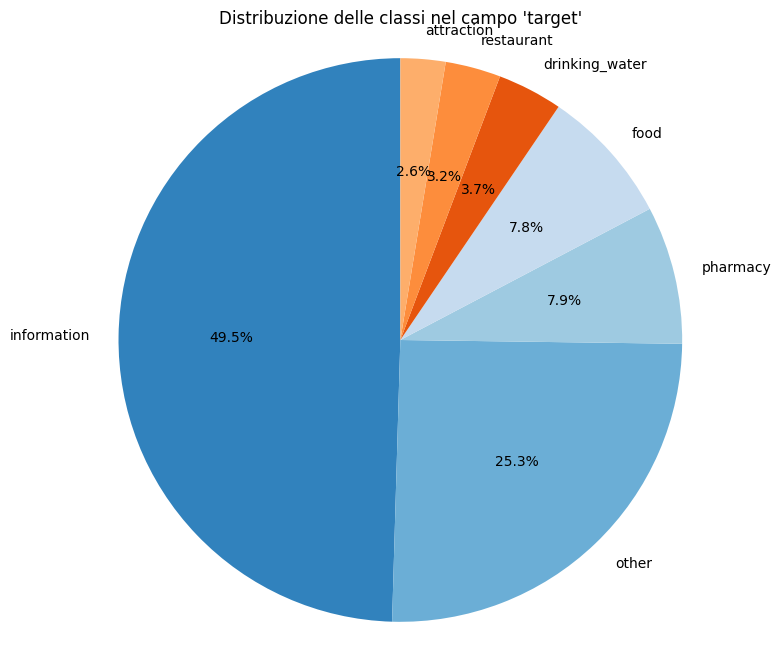

In [30]:
# Etichette e valori per il grafico
labels = df['target'].value_counts().keys()
sizes = df['target'].value_counts()

# Creazione del grafico a torta
plt.figure(figsize=(8, 8))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=plt.cm.tab20c.colors
)
plt.title("Distribuzione delle classi nel campo 'target'")
plt.axis('equal')  
plt.show()

 Questa distribuzione evidenzia un certo sbilanciamento, con un alto numero di occorrenze per alcune categorie principali e un numero minore per altre. 

### Valutazione della qualità dei dati

Questa fase ha l'obiettivo di eseguire controlli preliminari sul dataset per identificare rapidamente anomalie, inconsistenze e problemi comuni che potrebbero influenzare negativamente le analisi successive. Durante i **sanity checks**, si esaminano aspetti come:

* **Valori Mancanti**: identificazione delle colonne o righe con una percentuale significativa di dati nulli.
* **Valori Duplicati o Incoerenti**: verifica che mira ad individuare righe ripetute all'interno del dataset, che potrebbero rappresentare informazioni ridondanti, oppure dati che non rispettano il formato atteso o contraddicono le regole del dominio.
* **Cardinalità**: verifica del numero di categorie uniche nelle variabili categoriche, utile per rilevare livelli inaspettati o rumore. 

Questi controlli iniziali forniscono una panoramica dello stato del dataset e permettono di identificare priorità per interventi di pulizia.

#### Valori Mancanti

In [31]:
# Controlliamo i valori nulli e la percentuale di dati mancanti
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
print("Valori nulli e percentuali per colonna:")
print(pd.DataFrame({'Missing Count': missing_data, 'Missing %': missing_percentage}))

Valori nulli e percentuali per colonna:
                  Missing Count  Missing %
@id                           0   0.000000
addr:city                  1963  73.328353
addr:housenumber           1915  71.535301
addr:postcode              2002  74.785207
addr:street                1893  70.713485
...                         ...        ...
fax_1                      2676  99.962645
service_times              2676  99.962645
brand:website              2676  99.962645
armrest                    2675  99.925290
target                        0   0.000000

[502 rows x 2 columns]


In [32]:
# Mostriamo solo le colonne con meno del 60% di valori mancanti
print("Colonne con meno del 60% di valori mancanti:")
print(missing_percentage[missing_percentage < 60])

Colonne con meno del 60% di valori mancanti:
@id                0.000000
description:it     0.000000
name              33.993276
operator          52.857677
source            52.110572
hiking            58.946582
information       50.466941
target             0.000000
dtype: float64


In [33]:
# Filtriamo il DataFrame per mantenere solo le colonne selezionate
columns_to_keep = ['@id', 'name', 'description:it', 'operator', 'source', 'hiking', 'information', 'target']
df = df[columns_to_keep]

# Visualizziamo i primi dati filtrati
df.head()

,@id,name,description:it,operator,source,hiking,information,target
0,node/254087448,Farmacia Zenobii,orari attuale e turno sul sito web,Dott. Fabrizio Zenobii,Ministero della Salute,NaN,NaN,pharmacy
1,node/254087764,Farmacia Cantò,orarfi attuale e turni sul sito web,CANTO' DI CROCE CANTO' & C. SNC,Ministero della Salute,NaN,NaN,pharmacy
2,node/298376518,Antico Caffè Torinese,"Più di una semplice caffetteria, rappresenta u...",NaN,NaN,NaN,NaN,other
3,node/302324772,Cinema teatro Verdi,"Proiezioni cinematografiche, spettacoli teatra...",NaN,NaN,NaN,NaN,other
4,node/302369315,NaN,Vista sulla citta' di Genova ed aree circostanti,NaN,NaN,NaN,NaN,other


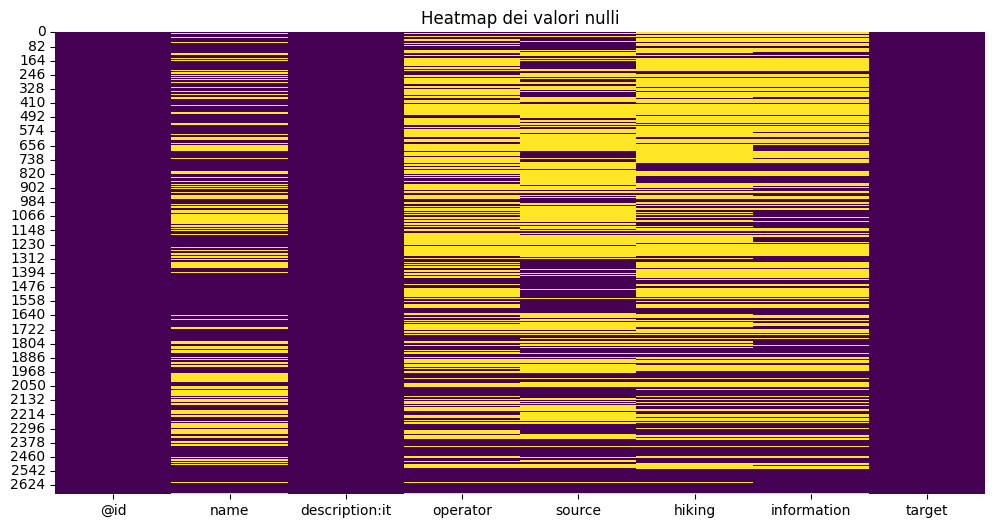

In [34]:
# Visualizziamo graficamente i dati mancanti
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap dei valori nulli")
plt.show()

La heatmap presentata mostra la distribuzione dei valori mancanti (nulli) all'interno del dataset. Ogni riga rappresenta un'osservazione (o elemento) del dataset, mentre ogni colonna rappresenta una variabile (o feature). I colori della heatmap indicano la presenza o l'assenza di dati:

* Viola: valori presenti.
* Giallo: valori mancanti (nulli).

La maggior parte delle righe presenta valori mancanti almeno in alcune colonne.
Alcune colonne hanno una densità particolarmente elevata di valori nulli, suggerendo la possibilità che queste variabili contengano informazioni scarsamente rilevanti o incomplete per l'analisi.

L'analisi dei valori nulli è un passo fondamentale per garantire la qualità del dataset e, di conseguenza, la robustezza dei risultati ottenuti durante il progetto. Interventi mirati per trattare i valori mancanti contribuiranno a migliorare sia la precisione del modello che la validità delle conclusioni.

#### Valori Duplicati o Incoerenti

Utilizziamo il metodo di deduplica in Python con Pandas per identificare i duplicati nel dataset.

In [35]:
# Identifichiamo duplicati in colonne specifiche (in quanto gli id sono generati automaticamente da OSM, quindi per forza diversi)
duplicates = df[df.duplicated(subset=['name', 'description:it'], keep=False)]
print(duplicates)

                   @id name                                 description:it   
64      node/763617844  NaN                     sorgente di acqua pubblico  \
121    node/1326231219  NaN          Tabella segnavia del sentiero CAI 736   
122    node/1326231290  NaN          Tabella segnavia del sentiero CAI 736   
123    node/1330073712  NaN                        Riparo naturale (barma)   
124    node/1330074109  NaN                        Riparo naturale (barma)   
...                ...  ...                                            ...   
2484  node/11801650690  NaN          Tabella segnavia del sentiero CAI 736   
2485  node/11801650691  NaN          Tabella segnavia del sentiero CAI 736   
2504  node/11968697235  NaN                   Barriera convalida biglietti   
2672  node/12360052612  NaN  panchina rossa contro la violenza sulle donne   
2673  node/12360052613  NaN  panchina rossa contro la violenza sulle donne   

                  operator                        source hiking

In [36]:
len(duplicates)

382

Nel contesto dei dati estratti da OpenStreetMap (OSM), ogni punto di interesse (POI) viene identificato da un ID univoco che è automaticamente assegnato dal sistema, garantendo che ogni istanza abbia un riferimento distinto. Questo sistema di identificazione univoca riduce significativamente il rischio di duplicati effettivi a livello di dati grezzi.

Nonostante questo, possono esistere situazioni in cui due POI condividano lo stesso nome e la stessa descrizione, ma rappresentino entità distinte (ad esempio, lo stesso nome per farmacie appartenenti a una catena o descrizioni simili per punti di interesse in località diverse).

Per verificare se i POI apparentemente duplicati (con nome e descrizione identici) rappresentano effettivamente delle duplicazioni errate, si potrebbe analizzare ulteriormente le informazioni disponibili, ad esempio verificando la loro posizione geografica tramite la latitudine e la longitudine.

Nel nostro dataset, si osserva che su un totale di 2677 istanze, solo 382 POI sono risultati avere lo stesso nome e la stessa descrizione. Questo valore rappresenta una percentuale trascurabile (~14%) del dataset complessivo. Considerando che i duplicati effettivi potrebbero essere minimi e che l'impatto sulla qualità del dataset complessivo è marginale, abbiamo deciso di mantenere tutte le istanze per semplicità.

Questa scelta consente di preservare la completezza dei dati senza introdurre potenziali errori legati all'eliminazione non corretta di entità valide.

Per quanto riguarda le incoerenze, invece, cominciamo con il campo **"description"**, cercando discrepanze come typo o formattazioni multiple.

In [37]:
# Pipeline completa
df['description:it'] = (
    df['description:it']
    .str.strip()  # Rimuove spazi extra
    .str.lower()  # Converte in minuscolo
    .apply(normalize_text)  # Normalizza Unicode
    .str.replace(r'\s+', ' ', regex=True)  # Uniforma gli spazi
)

In [38]:
threshold = 90  # Definiamo la soglia di somiglianza (90%)
potenziali_incoerenze = []

for i, desc in enumerate(df['description:it']):
    for j, other_desc in enumerate(df['description:it']):
        if i < j and fuzz.ratio(desc, other_desc) >= threshold:  # Evita confronti ripetitivi
            potenziali_incoerenze.append((i, j, desc, other_desc, fuzz.ratio(desc, other_desc)))

In [39]:
# Visualizziamo potenziali incoerenze con somiglianza < 100%
for i, j, desc1, desc2, score in potenziali_incoerenze:
    if score < 100:  # Filtriamo solo le coppie con somiglianza < 100%
        print(f"Incoerenza tra riga {i} e {j}:\n'{desc1}'\nvs\n'{desc2}'\nSomiglianza: {score}%")

Incoerenza tra riga 0 e 1:
'orari attuale e turno sul sito web'
vs
'orarfi attuale e turni sul sito web'
Somiglianza: 96%
Incoerenza tra riga 0 e 34:
'orari attuale e turno sul sito web'
vs
'orari attuale e turno sul sito web.'
Somiglianza: 99%
Incoerenza tra riga 0 e 269:
'orari attuale e turno sul sito web'
vs
'orario attuale e turno sul sito web.'
Somiglianza: 97%
Incoerenza tra riga 0 e 1235:
'orari attuale e turno sul sito web'
vs
'orari attuale e turnosul sito web'
Somiglianza: 99%
Incoerenza tra riga 0 e 1935:
'orari attuale e turno sul sito web'
vs
'orari attuale e turno sul sito web.'
Somiglianza: 99%
Incoerenza tra riga 0 e 2007:
'orari attuale e turno sul sito web'
vs
'orari attuale e turno sul sito web.'
Somiglianza: 99%
Incoerenza tra riga 0 e 2069:
'orari attuale e turno sul sito web'
vs
'orari attuale e turnu sul sito web'
Somiglianza: 97%
Incoerenza tra riga 0 e 2070:
'orari attuale e turno sul sito web'
vs
'orari attuale e turno sul sito web.'
Somiglianza: 99%
Incoeren

Nella fase di pulizia, procederemo con l'identificare gruppi di descrizioni simili (ad esempio, per raggruppare incoerenze), e quindi con il pulire il seguente campo.

In [40]:
df['source'].value_counts()

source
survey:CAI                                                                                                                    651
ds4273                                                                                                                        250
Ministero della Salute                                                                                                        140
survey:CAI Pallanza                                                                                                            59
Refill Südtirol / Alto Adige                                                                                                   55
DUC Bergamo                                                                                                                    34
survey                                                                                                                         32
knowledge                                                                          

Salviamo pertanto le frasi che hanno una somiglianza < 100% per poterle visionare in seguito:

In [41]:
# Creiamo un DataFrame da `potenziali_incoerenze`
filtro = pd.DataFrame(potenziali_incoerenze, columns=['ID1', 'ID2', 'Frase Originale', 'Frase Confrontata', 'Somiglianza'])

# Filtriamo solo le righe con Somiglianza < 100
filtered_df = filtro[filtro['Somiglianza'] < 100]

# Salviamo il risultato in un file Excel
filtered_df.to_excel("frasi_somiglianza_inferiore_a_100.xlsx", index=False)

print("File Excel salvato con successo.")

File Excel salvato con successo.


Faremo la stessa cosa con **'source'**, che diventerà categorica.

In [42]:
df['information'].value_counts()

information
guidepost       1103
board            120
route_marker      55
map               39
qrcode             5
loc_name           2
office             1
sign               1
Name: count, dtype: int64

Con **"information"**, invece, non sarà necessario.

#### Cardinalità


Ora valutiamo la cardinalità di ciascuna feature categorica:

In [43]:
# 'source' contiene informazioni sulla provenienza dei dati
df['source'].value_counts()

source
survey:CAI                                                                                                                    651
ds4273                                                                                                                        250
Ministero della Salute                                                                                                        140
survey:CAI Pallanza                                                                                                            59
Refill Südtirol / Alto Adige                                                                                                   55
DUC Bergamo                                                                                                                    34
survey                                                                                                                         32
knowledge                                                                          

In [44]:
# quantità diverse di 'source'
len(df['source'].value_counts())

29

Categorizzare e unificare alcune categorie è un'ottima strategia di data cleaning per questa feature. Questo ci aiuterà a ridurre la variabilità causata da piccoli errori di battitura o differenze nella nomenclatura e a rendere i dati più consistenti per l'analisi.

In [45]:
# 'hiking' contiene informazioni sulle attività di trekking
df['hiking'].value_counts()

hiking
yes                             909
no                              187
yes""information"="guidepost      3
Name: count, dtype: int64

Anche in questo caso categorizzeremo, ma in tre categorie: 'yes', 'no' e 'null'.

In [46]:
# 'information' contiene informazioni aggiuntive
df['information'].value_counts()

information
guidepost       1103
board            120
route_marker      55
map               39
qrcode             5
loc_name           2
office             1
sign               1
Name: count, dtype: int64

Con "information", infine, procederemo ad unificare in "other" le classi con frequenza minore di 10.

### Analisi della Struttura del dataset

#### Rappresentazione delle feature

In questa sezione ci concentriamo sulla trasformazione delle feature, attualmente tutte di tipo "object", in valori numerici adatti all'utilizzo con un classificatore.

In [47]:
print("\nTipi di dati per ogni colonna:")
print(df.dtypes)


Tipi di dati per ogni colonna:
@id               object
name              object
description:it    object
operator          object
source            object
hiking            object
information       object
target            object
dtype: object


Iniziamo trasformando il target in una variabille categorica:

In [48]:
df['target'] = df['target'].astype('category')

In [49]:
print("\nTipi di dati per ogni colonna:")
print(df.dtypes)


Tipi di dati per ogni colonna:
@id                 object
name                object
description:it      object
operator            object
source              object
hiking              object
information         object
target            category
dtype: object


Eliminiamo la feature "@id" in quanto non è utile al fine della classificazione:

In [50]:
# Eliminiamo la feature '@id' poiché non è informativa
df = df.drop(columns=['@id'])

In [51]:
df.head()

,name,description:it,operator,source,hiking,information,target
0,Farmacia Zenobii,orari attuale e turno sul sito web,Dott. Fabrizio Zenobii,Ministero della Salute,NaN,NaN,pharmacy
1,Farmacia Cantò,orarfi attuale e turni sul sito web,CANTO' DI CROCE CANTO' & C. SNC,Ministero della Salute,NaN,NaN,pharmacy
2,Antico Caffè Torinese,"più di una semplice caffetteria, rappresenta u...",NaN,NaN,NaN,NaN,other
3,Cinema teatro Verdi,"proiezioni cinematografiche, spettacoli teatra...",NaN,NaN,NaN,NaN,other
4,NaN,vista sulla citta' di genova ed aree circostanti,NaN,NaN,NaN,NaN,other


In [52]:
df['operator'].value_counts()

operator
Club Alpino Italiano                                                          275
Parchi del Ducato                                                             190
Club Alpino Italiano - Sezione di Parma - Gruppo territoriale Alta Valtaro    106
Club Alpino Italiano Sezione di Pallanza                                       54
Club Alpino Italiano Sezione di Parma                                          38
                                                                             ... 
Bruno di Nardo                                                                  1
Alessandro Aloi                                                                 1
Dr. Antonio Antonioli & C. SAS                                                  1
Farmacia Richeri                                                                1
Dr. Luigi Libertini                                                             1
Name: count, Length: 407, dtype: int64

Ora ci occupiamo delle feature descrittive e narrative, quali: "name", "description:it" e "operator".

In [53]:
# Convertiamo in lowercase
df['description:it'] = df['description:it'].str.lower()
df["name"] = df['name'].str.lower()
df["operator"] = df['operator'].str.lower()

In [54]:
# Convertiamo in stringa
df['description:it'] = df['description:it'].astype(str)
df["name"] = df['name'].astype(str)
df["operator"] = df['operator'].astype(str)

Iniziamo a creare il dataset **"df_1"**, che sarà la nostra baseline.

In [55]:
df_1 = df.copy()

In [56]:
# Tokenizziamo
df_1['description:it'] = df_1['description:it'].apply(lambda x: tokenizer(x))
df_1['name'] = df_1['name'].apply(lambda x: tokenizer(x))   
df_1['operator'] = df_1['operator'].apply(lambda x: tokenizer(x))

In [57]:
df_1.head()

,name,description:it,operator,source,hiking,information,target
0,"(farmacia, zenobii)","(orari, attuale, e, turno, sul, sito, web)","(dott, ., fabrizio, zenobii)",Ministero della Salute,NaN,NaN,pharmacy
1,"(farmacia, cantò)","(orarfi, attuale, e, turni, sul, sito, web)","(canto, ', , di, croce, canto, ', &, c., snc)",Ministero della Salute,NaN,NaN,pharmacy
2,"(antico, caffè, torinese)","(più, di, una, semplice, caffetteria, ,, rappr...",(nan),NaN,NaN,NaN,other
3,"(cinema, teatro, verdi)","(proiezioni, cinematografiche, ,, spettacoli, ...",(nan),NaN,NaN,NaN,other
4,(nan),"(vista, sulla, citta, ', di, genova, ed, aree,...",(nan),NaN,NaN,NaN,other


In [58]:
df_1['description:it'] = df_1['description:it'].apply(lambda x: ' '.join([token.text for token in x]))
df_1['name'] = df_1['name'].apply(lambda x: ' '.join([token.text for token in x]))
df_1['operator'] = df_1['operator'].apply(lambda x: ' '.join([token.text for token in x]))

df_1.head()

,name,description:it,operator,source,hiking,information,target
0,farmacia zenobii,orari attuale e turno sul sito web,dott . fabrizio zenobii,Ministero della Salute,NaN,NaN,pharmacy
1,farmacia cantò,orarfi attuale e turni sul sito web,canto ' di croce canto ' & c. snc,Ministero della Salute,NaN,NaN,pharmacy
2,antico caffè torinese,"più di una semplice caffetteria , rappresenta ...",nan,NaN,NaN,NaN,other
3,cinema teatro verdi,"proiezioni cinematografiche , spettacoli teatr...",nan,NaN,NaN,NaN,other
4,nan,vista sulla citta ' di genova ed aree circostanti,nan,NaN,NaN,NaN,other


Per il momento scegliamo di tokenizzare 'source' per semplicità. In una fase successiva approcceremo tecniche di pulizia dei dati per decidere come approcciare al meglio questi dati.

In [59]:
df_1['source'] = df_1['source'].str.lower()
df_1['source'] = df_1['source'].astype(str)
df_1['source'] = df_1['source'].apply(lambda x: tokenizer(x))
df_1['source'] = df_1['source'].apply(lambda x: ' '.join([token.text for token in x]))

In [60]:
df_1.head()

,name,description:it,operator,source,hiking,information,target
0,farmacia zenobii,orari attuale e turno sul sito web,dott . fabrizio zenobii,ministero della salute,NaN,NaN,pharmacy
1,farmacia cantò,orarfi attuale e turni sul sito web,canto ' di croce canto ' & c. snc,ministero della salute,NaN,NaN,pharmacy
2,antico caffè torinese,"più di una semplice caffetteria , rappresenta ...",nan,nan,NaN,NaN,other
3,cinema teatro verdi,"proiezioni cinematografiche , spettacoli teatr...",nan,nan,NaN,NaN,other
4,nan,vista sulla citta ' di genova ed aree circostanti,nan,nan,NaN,NaN,other


Per la feature "hiking", invece, scegliamo di trasformarla in una variabile categorica, dato che contiene solo tre tipi di valori distinti.

Prima però, è necessario riempire i campi *null* per considerarli un'altra categoria, e unificarli alle tre istanze che hanno il campo riempito come "*yes''information'='guidepost*":

In [61]:
# se il valore è NaN, impostiamo il valore su 'null'
df['hiking'] = df['hiking'].fillna('null')

# se il valore è 'yes"information"="guidepost' impostiamo il valore su 'null
df['hiking'] = df['hiking'].apply(lambda x: 'null' if x == 'yes""information"="guidepost' else x)

In [62]:
df['hiking'] = df['hiking'].astype('category')

In [63]:
df_1['hiking'] = df['hiking']   
df_1['hiking'].value_counts()

hiking
null    1581
yes      909
no       187
Name: count, dtype: int64

In [64]:
df_1['information'].value_counts()

information
guidepost       1103
board            120
route_marker      55
map               39
qrcode             5
loc_name           2
office             1
sign               1
Name: count, dtype: int64

Facciamo lo stesso anche per "information" preoccupandoci però di unificare in "other" le classi con frequenza minore di 10:

In [65]:
# Gestiamo i NaN
df['information'] = df['information'].fillna('missing')

In [66]:
threshold = 10
frequent_information = df['information'].value_counts()
df['information'] = df['information'].apply(lambda x: x if frequent_information[x] >= threshold else "other")

In [67]:
df['information'].value_counts()

information
missing         1351
guidepost       1103
board            120
route_marker      55
map               39
other              9
Name: count, dtype: int64

In [68]:
df['information'] = df['information'].astype('category')
df_1['information'] = df['information']

A questo punto però, non abbiamo ancora ottenuto un dataset che possa essere dato in input ad un classificatore, infatti:
* Anche se una variabile è di tipo category in pandas, i modelli di machine learning richiedono variabili numeriche normalizzate o vettorizzate. 
* I classificatori come Decision Tree o SVM necessitano di feature numeriche, e le nostre feature testuali sono ancora sottoforma di token.

In [69]:
df_1.dtypes

name                object
description:it      object
operator            object
source              object
hiking            category
information       category
target            category
dtype: object

Procediamo pertanto a sistemarlo:
 

In [70]:
# Vettorizziamo le variabili categoriche
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df_1[['hiking', 'information']])
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out())
df_1 = pd.concat([df_1, encoded_df], axis=1)
df_1.drop(['hiking', 'information'], axis=1, inplace=True)

Siccome il target deve essere categoriale numerico, utilizziamo **Label Encoder** di scikit-learn per preparare la colonna target. 
Esso mappa ciascuna categoria della colonna target a un numero. 

In [71]:
label_encoder = LabelEncoder()

# Trasformiamo i valori categoriali della colonna target in numerici
df_1['target'] = label_encoder.fit_transform(df_1['target']) 

# Mostriamo il mapping tra categorie originali e valori numerici
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Mapping delle categorie:")
print(mapping)

In [72]:
df_1.head()

,name,description:it,operator,source,target,hiking_no,hiking_null,hiking_yes,information_board,information_guidepost,information_map,information_missing,information_other,information_route_marker
0,farmacia zenobii,orari attuale e turno sul sito web,dott . fabrizio zenobii,ministero della salute,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,farmacia cantò,orarfi attuale e turni sul sito web,canto ' di croce canto ' & c. snc,ministero della salute,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,antico caffè torinese,"più di una semplice caffetteria , rappresenta ...",nan,nan,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,cinema teatro verdi,"proiezioni cinematografiche , spettacoli teatr...",nan,nan,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,nan,vista sulla citta ' di genova ed aree circostanti,nan,nan,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Per quanto riguarda la vettorizzazione del testo, invece, la rimandiamo a quando procederemo con la classificazione, per facilitare la "lettura del dataset". Maggiori dettagli sono disponibili nella sezione dedicata alla "*Rappresentazione vettoriale delle feature testuali*".

Con queste operazioni abbiamo ottenuto il primo dataset (*df_1*), che contiene dati etichettati e codificati ma ancora non puliti.

In [73]:
# Salviamolo 
df_1.to_excel('df_1.xlsx', index=False)

Ora procediamo con la costruzione di altri due dataset.

Il dataset *df_2* sarà composto solo dalle due caratteristiche testuali name e description:it, e verrà utilizzato come termine di paragone per dimostrare che l'inclusione delle altre colonne nel dataset contribuisce a migliorare le prestazioni dei modelli.

Eliminiamo le incoerenze da 'description:it', facendo riferimento al file salvato precedentemente:

In [74]:
# Visualizziamo potenziali incoerenze con somiglianza < 100%
for i, j, desc1, desc2, score in potenziali_incoerenze:
    if score < 100:  # Filtriamo solo le coppie con somiglianza < 100%
        print(f"Incoerenza tra riga {i} e {j}:\n'{desc1}'\nvs\n'{desc2}'\nSomiglianza: {score}%")

Incoerenza tra riga 0 e 1:
'orari attuale e turno sul sito web'
vs
'orarfi attuale e turni sul sito web'
Somiglianza: 96%
Incoerenza tra riga 0 e 34:
'orari attuale e turno sul sito web'
vs
'orari attuale e turno sul sito web.'
Somiglianza: 99%
Incoerenza tra riga 0 e 269:
'orari attuale e turno sul sito web'
vs
'orario attuale e turno sul sito web.'
Somiglianza: 97%
Incoerenza tra riga 0 e 1235:
'orari attuale e turno sul sito web'
vs
'orari attuale e turnosul sito web'
Somiglianza: 99%
Incoerenza tra riga 0 e 1935:
'orari attuale e turno sul sito web'
vs
'orari attuale e turno sul sito web.'
Somiglianza: 99%
Incoerenza tra riga 0 e 2007:
'orari attuale e turno sul sito web'
vs
'orari attuale e turno sul sito web.'
Somiglianza: 99%
Incoerenza tra riga 0 e 2069:
'orari attuale e turno sul sito web'
vs
'orari attuale e turnu sul sito web'
Somiglianza: 97%
Incoerenza tra riga 0 e 2070:
'orari attuale e turno sul sito web'
vs
'orari attuale e turno sul sito web.'
Somiglianza: 99%
Incoeren

In [75]:
# Creiamo una mappa per unificare descrizioni simili
unificare = {
    'orarfi': 'orari',
    'turnosul': 'turni sul',
    'turnu': 'turni',
    'turno': 'turni',
    'orari attuale': 'orari attuali',
    'e orari sul sito '
    'vnde': 'vende'
}

In [76]:
# Applichiamo la pulizia al dataset
df['description:it'] = df['description:it'].apply(lambda x: pulisci_descrizione(x, unificare))

In [77]:
# Verifichiamo che le descrizioni siano uniformi
df['description:it'].unique() 

array(['orari attuali e turni sul sito web',
       'più di una semplice caffetteria, rappresenta un vero salto nel attività, il nobi ancora oggi, a tutti i suoi ospiti ...',
       'proiezioni cinematografiche, spettacoli teatrali, intrattenimenti musicali,conferenze',
       ..., 'negozio che vnde caramelle svedesi',
       "dipinto di carattere religioso che ricopre l'intero portone di legno.",
       'pasticceria e caffè con sala da tè'], dtype=object)

In [78]:
df_2 = df.copy()

In [79]:
df_2.drop(['source', 'operator', 'hiking', 'information'], axis=1, inplace=True)

In [80]:
df_2['target'] = df_1['target']

In [81]:
df_2.head()

,name,description:it,target
0,farmacia zenobii,orari attuali e turni sul sito web,5
1,farmacia cantò,orari attuali e turni sul sito web,5
2,antico caffè torinese,"più di una semplice caffetteria, rappresenta u...",4
3,cinema teatro verdi,"proiezioni cinematografiche, spettacoli teatra...",4
4,nan,vista sulla citta' di genova ed aree circostanti,4


A questo punto effettuiamo un po' di operazioni di **preprocessing**, tra cui:
* Rimozione di punteggiatura
* Rimozione di stopwords
* Rimozione di numeri
* Lemmatizzazione

In [82]:
df_2['description:it'] = df_2['description:it'].apply(preprocess_text)
df_2['name'] = df_2['name'].apply(preprocess_text)

In [83]:
# Mostriamo il risultato
df_2.head()

,name,description:it,target
0,farmacia zenobio,orario attuale turno sito web,5
1,farmacia cantare,orario attuale turno sito web,5
2,antico caffè torinese,semplice caffetteria rappresentare vero salto ...,4
3,cinema teatro verde,proiezione cinematografico spettacolo teatrale...,4
4,nan,vedere genova area circostante,4


In [84]:
# Salviamolo 
df_2.to_excel('df_2.xlsx', index=False)

Mancando solo la vettorizzazione del testo, ancora una volta rimandiamo alla sezione *"Rappresentazione delle feature testuali"*, in cui concluderemo la creazione di *df_2*.

Infine, generiamo il dataset *df_3*, completo, pulito e privo di inconsistenze.

Per quanto riguarda le feature *name* e *description:it*, ci limitiamo a copiare quelle già pulite e preprocessate di *df_2*. *operator* lo preprocessiamo e tutte le altre feature categoriche le copiamo da *df_1*.

In [85]:
df_3 = df_1.copy()
df_3['name'] = df_2['name']
df_3['description:it'] = df_2['description:it']
df_3['operator'] = df['operator'].apply(preprocess_text)

In [86]:
df_3.head()

,name,description:it,operator,source,target,hiking_no,hiking_null,hiking_yes,information_board,information_guidepost,information_map,information_missing,information_other,information_route_marker
0,farmacia zenobio,orario attuale turno sito web,dott fabrizio zenobio,ministero della salute,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,farmacia cantare,orario attuale turno sito web,canto croce canto c. snc,ministero della salute,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,antico caffè torinese,semplice caffetteria rappresentare vero salto ...,nan,nan,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,cinema teatro verde,proiezione cinematografico spettacolo teatrale...,nan,nan,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,nan,vedere genova area circostante,nan,nan,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Infine, manca solo da categorizzare *source*. Prima di farlo, dobbiamo pulirlo, rimuovendo le inconsistenze e uniformando le categorie di cui è composto.

In [87]:
df_3['source'].value_counts()

source
nan                                                                                                                           1395
survey : cai                                                                                                                   651
ds4273                                                                                                                         250
ministero della salute                                                                                                         140
survey : cai pallanza                                                                                                           59
refill südtirol / alto adige                                                                                                    55
duc bergamo                                                                                                                     34
survey                                                                      

In [88]:
# Creiamo una mappa per unificare descrizioni simili
unificare = {
    'survey : cai pallanza': 'survey : cai',
    'ministerio': 'ministero',
    'minestero': 'ministero',
    'ministgero': 'ministero',
    'saòlute': 'salute',
    'mise ministero dello sviluppo economico': 'ministero dello sviluppo economico',
    'miniistero': 'ministero',
    'satute': 'salute',
    'saluta': 'salute',
    'survey : cai': 'survey',
    'duc bergamo;survey': 'survey'
}

In [89]:
# Applichiamo la pulizia al dataset
df_3['source'] = df_3['source'].apply(lambda x: pulisci_descrizione(x, unificare))

In [90]:
# Verifichiamo che le descrizioni siano uniformi
df_3['source'].value_counts()

source
nan                                                                                                                           1395
survey                                                                                                                         743
ds4273                                                                                                                         250
ministero della salute                                                                                                         147
refill südtirol / alto adige                                                                                                    55
duc bergamo                                                                                                                     34
knowledge                                                                                                                       21
www.comune.fi.it/spesadovecome/                                             

In [91]:
# Convertiamo in 'other' tutte le categorie con meno di 30 occorrenze
threshold = 30
frequent_source = df_3['source'].value_counts()
df_3['source'] = df_3['source'].apply(lambda x: x if frequent_source[x] >= threshold else "other")

In [92]:
# La categoria 'nan' diventa 'other'
df_3['source'] = df_3['source'].replace('nan', 'other')

In [93]:
df_3['source'].value_counts()

source
other                           1448
survey                           743
ds4273                           250
ministero della salute           147
refill südtirol / alto adige      55
duc bergamo                       34
Name: count, dtype: int64

In [94]:
# trasformiamo la feature in categorica
df_3['source'] = df_3['source'].astype('category')

In [95]:
# La vettorizziamo
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df_3['source'].to_frame())
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out())
df_3 = pd.concat([df_3, encoded_df], axis=1)
df_3.drop(['source'], axis=1, inplace=True)

In [96]:
df_3.head()

,name,description:it,operator,target,hiking_no,hiking_null,hiking_yes,information_board,information_guidepost,information_map,information_missing,information_other,information_route_marker,source_ds4273,source_duc bergamo,source_ministero della salute,source_other,source_refill südtirol / alto adige,source_survey
0,farmacia zenobio,orario attuale turno sito web,dott fabrizio zenobio,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,farmacia cantare,orario attuale turno sito web,canto croce canto c. snc,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,antico caffè torinese,semplice caffetteria rappresentare vero salto ...,nan,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,cinema teatro verde,proiezione cinematografico spettacolo teatrale...,nan,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,nan,vedere genova area circostante,nan,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Mancando solo la vettorizzazione del testo, ancora una volta rimandiamo alla sezione *"Rappresentazione delle feature testuali"*, in cui concluderemo la creazione di *df_3*.

In [97]:
# Salviamo il dataset
df_3.to_excel('df_3.xlsx', index=False) 

#### Valori Utili

Per determinare se le feature selezionate sono utili per la classificazione, possiamo applicare diverse tecniche statistiche e machine learning, tra cui il **Chi-Quadrato**, un test statistico per misurare la dipendenza tra le feature categoriali e il target.

In [98]:
df.head()

,name,description:it,operator,source,hiking,information,target
0,farmacia zenobii,orari attuali e turni sul sito web,dott. fabrizio zenobii,Ministero della Salute,null,missing,pharmacy
1,farmacia cantò,orari attuali e turni sul sito web,canto' di croce canto' & c. snc,Ministero della Salute,null,missing,pharmacy
2,antico caffè torinese,"più di una semplice caffetteria, rappresenta u...",nan,NaN,null,missing,other
3,cinema teatro verdi,"proiezioni cinematografiche, spettacoli teatra...",nan,NaN,null,missing,other
4,nan,vista sulla citta' di genova ed aree circostanti,nan,NaN,null,missing,other


In [99]:
df.dtypes

name                object
description:it      object
operator            object
source              object
hiking            category
information       category
target            category
dtype: object

In [100]:
df['hiking'].value_counts()

hiking
null    1581
yes      909
no       187
Name: count, dtype: int64

In [101]:
crosstab_hiking = pd.crosstab(df['hiking'], df['target'])
chi2_h, p_h, _, _ = chi2_contingency(crosstab_hiking)

In [102]:
crosstab_hiking

target,attraction,drinking_water,food,information,other,pharmacy,restaurant
hiking,,,,,,,
no,0,0,0,187,0,0,0
null,69,100,209,230,676,212,85
yes,0,0,0,909,0,0,0


Questa tabella di contingenza mostra come le variabili hiking e target sono correlate e distribuite attraverso le varie categorie.

In [103]:
print(f"\nFeature: hiking, p-value: {p_h}")


Feature: hiking, p-value: 0.0


Un **p-value di 0.0** indica che il risultato del test chi-quadro è altamente significativo. In altre parole, c'è una relazione molto forte tra le due variabili (in questo caso, la colonna hiking e la colonna target).

Possiamo quindi concludere che c'è una **relazione significativa tra le variabili**: ha assolutamente senso tenere la feature "hiking" al fine della classificazione.

Ripetiamo lo stesso procedimento per l'altra variabile categoriale, ovvero *information*:

In [104]:
crosstab_info = pd.crosstab(df['information'], df['target'])
chi2_i, p_i, _, _ = chi2_contingency(crosstab_info)

In [105]:
crosstab_info

target,attraction,drinking_water,food,information,other,pharmacy,restaurant
information,,,,,,,
board,0,0,0,120,0,0,0
guidepost,0,0,0,1103,0,0,0
map,0,0,0,39,0,0,0
missing,69,100,209,0,676,212,85
other,0,0,0,9,0,0,0
route_marker,0,0,0,55,0,0,0


In [106]:
print(f"\nFeature: hiking, p-value: {p_i}")


Feature: hiking, p-value: 0.0


Anche la feature "information" sembra essere rilevante al fine della classificazione: la teniamo.


## Dataset generati


Abbiamo dunque generato 3 diversi dataset, di cui andremo a confrontare le prestazioni:

* **df_1** -> contiene dati etichettati e codificati (ma ancora non puliti) propri di tutte le feature selezionate. 'source' è testuale. Serve come baseline.
* **df_2** -> contiene solo 'name' e 'description:it' come feature. Serve per dimostrare che le altre feature sono influenti per il miglioramento delle prestazioni.
* **df_3** -> dataset finale, completo, pulito e privo di incoerenze. 'source' è diventato categorico e le feature testuali sono state preprocessate.

## Rappresentazione vettoriale delle feature testuali

Processo di trasformazione dei dati di testo in rappresentazioni numeriche basate sui conteggi delle parole o su TF-IDF (Term Frequency-Inverse Document Frequency):

**fit()**: Questo metodo viene utilizzato per calcolare la media e la varianza dei dati di addestramento. Questi valori sono utilizzati per normalizzare o standardizzare i dati. Durante questo processo, il modello "impara" la distribuzione dei dati di addestramento.

**transform**(): Dopo aver calcolato media e varianza con il metodo fit(), il metodo transform() applica effettivamente la normalizzazione o standardizzazione ai dati. In altre parole, trasforma i dati utilizzando la media e la varianza precedentemente calcolate.

**fit_transform**(): Questo è un metodo combinato che esegue entrambe le operazioni contemporaneamente: calcola la media e la varianza dei dati di addestramento con fit() e applica poi la trasformazione con transform(). Questo metodo è spesso più efficiente in termini di tempo di calcolo rispetto all'esecuzione di fit() e transform() separatamente.

Nel contesto dell'addestramento di modelli di machine learning, si utilizza fit_transform() sui dati di addestramento in quanto si desidera calcolare la media e la varianza dei dati di addestramento e applicare quindi la trasformazione. Per i dati di test, si desidera applicare la stessa trasformazione utilizzata sui dati di addestramento, ma senza ricalcolare media e varianza, poiché ci si basa sulla stessa distribuzione dei dati di addestramento. Pertanto, si utilizza il metodo transform() sui dati di test, utilizzando i parametri (media e varianza) calcolati precedentemente sui dati di addestramento. Questo assicura che la trasformazione sia coerente tra i dati di addestramento e i dati di test.

La **varianza** misura quanto le osservazioni di una variabile casuale si discostano dalla loro media. In termini più semplici, la varianza rappresenta la dispersione dei dati attorno alla loro media. Se la varianza è alta, significa che i dati sono molto dispersi e si discostano in modo significativo dalla media; se la varianza è bassa, i dati sono meno dispersi e si concentrano intorno alla media.

La **covarianza**, d'altra parte, misura la relazione lineare tra due variabili. Se due variabili hanno una covarianza alta, significa che variano insieme in modo simile: se una variabile aumenta, l'altra tende ad aumentare, e viceversa. Se la covarianza è bassa o negativa, le due variabili variano in modo indipendente o inversamente correlato.

Se due elementi nel dataset hanno una covarianza alta, significa che sono fortemente correlati tra loro. Ciò può indicare che le due variabili hanno un'associazione stretta e si comportano in modo simile. Tuttavia, è importante notare che la covarianza non misura la forza della relazione tra le variabili, ma solo la direzione e l'entità della loro associazione. Una covarianza alta può indicare una forte relazione positiva, ma potrebbe anche essere il risultato di un'associazione spuria o casuale tra le variabili. Pertanto, è importante esaminare ulteriormente la relazione tra le variabili utilizzando altre metriche e considerazioni contestuali.

Per convertire l'insieme di documenti di testo in una matrice, utilizziamo quindi **TF-IDF** per pesare l'importanza delle parole. Il TF-IDF considera sia la frequenza della parola in un documento (TF) che l'inverso della frequenza del termine in tutti i documenti del corpus (IDF). Questo aiuta a dare più peso alle parole che sono importanti per un documento specifico ma non comuni nell'intero corpus.

### Per df_1

In [107]:
df_1.dtypes

name                         object
description:it               object
operator                     object
source                       object
target                        int32
hiking_no                   float64
hiking_null                 float64
hiking_yes                  float64
information_board           float64
information_guidepost       float64
information_map             float64
information_missing         float64
information_other           float64
information_route_marker    float64
dtype: object

In [108]:
# Vettorizziamo le variabili testuali

# Identifichiamo le colonne
text_columns = ["name", "description:it", 'operator', 'source']  # Le colonne testuali da vettorizzare
categorical_columns = [col for col in df_1.columns if col not in text_columns]  # Il resto delle colonne
categorical_columns.remove('target')

In [109]:
y_df1 = df_1["target"]  
X_df1 = df_1.drop(columns=['target'])


# Dividiamo il dataset in training, validation e test set
X_train_df1, X_temp_df1, y_train_df1, y_temp_df1 = train_test_split(X_df1, y_df1, test_size=0.4, random_state=42)
X_validation_df1, X_test_df1, y_validation_df1, y_test_df1 = train_test_split(X_temp_df1, y_temp_df1, test_size=0.5, random_state=42)

In [110]:
X_train_df1.shape, X_validation_df1.shape, X_test_df1.shape

((1606, 13), (535, 13), (536, 13))

In [111]:
# Creiamo il vettorizzatore
vectorizer = TfidfVectorizer()

# Combiniamo tutte le colonne testuali del training set in una matrice unica
X_train_combined = X_train_df1[text_columns].apply(lambda row: ' '.join(row), axis=1)

# Vettorizziamo l'insieme di training
X_train_tfidf = vectorizer.fit_transform(X_train_combined)

# Combiniamo tutte le colonne testuali del validation set
X_validation_combined = X_validation_df1[text_columns].apply(lambda row: ' '.join(row), axis=1)

# Vettorizziamo l'insieme di validation
X_validation_tfidf = vectorizer.transform(X_validation_combined)

# Combiniamo tutte le colonne testuali del test set
X_test_combined = X_test_df1[text_columns].apply(lambda row: ' '.join(row), axis=1)

# Vettorizziamo l'insieme di test
X_test_tfidf = vectorizer.transform(X_test_combined)

In [112]:
categorical_data_training = X_train_df1[categorical_columns].values
categorical_data_validation = X_validation_df1[categorical_columns].values
categorical_data_test = X_test_df1[categorical_columns].values

In [113]:
categorical_data_training.shape, categorical_data_validation.shape, categorical_data_test.shape

((1606, 9), (535, 9), (536, 9))

In [114]:
# Ci assicuriamo che i dati categoriali siano sparsi (se sono densi)
categorical_data_training_sparse = csr_matrix(categorical_data_training)
categorical_data_validation_sparse = csr_matrix(categorical_data_validation)
categorical_data_test_sparse = csr_matrix(categorical_data_test)

# Combiniamo i dati di training (TF-IDF sparse matrix + colonne categoriali sparse)
X_training_df1 = hstack([X_train_tfidf, categorical_data_training_sparse])
print("Shape finale delle features di training:", X_training_df1.shape) 

# Combiniamo i dati di validation (TF-IDF sparse matrix + colonne categoriali sparse)
X_validation_df1 = hstack([X_validation_tfidf, categorical_data_validation_sparse])
print("Shape finale delle features di validation:", X_validation_df1.shape)

# Combiniamo i dati di test (TF-IDF sparse matrix + colonne categoriali sparse)
X_test_df1 = hstack([X_test_tfidf, categorical_data_test_sparse])
print("Shape finale delle features di test:", X_test_df1.shape)

Shape finale delle features di training: (1606, 4513)
Shape finale delle features di validation: (535, 4513)
Shape finale delle features di test: (536, 4513)


### Per df_2

In [115]:
df_2.dtypes

name              object
description:it    object
target             int32
dtype: object

In [116]:
# Vettorizziamo le variabili testuali

# Identifichiamo le colonne
text_columns = ["name", "description:it"]  # Le colonne testuali da vettorizzare

In [117]:
y_df2 = df_2["target"]  
X_df2 = df_2.drop(columns=['target'])

# Dividiamo il dataset in training, validation e test set
X_train_df2, X_temp_df2, y_train_df2, y_temp_df2 = train_test_split(X_df2, y_df2, test_size=0.4, random_state=42)
X_validation_df2, X_test_df2, y_validation_df2, y_test_df2 = train_test_split(X_temp_df2, y_temp_df2, test_size=0.5, random_state=42)

In [118]:
X_train_df2.shape, X_validation_df2.shape, X_test_df2.shape

((1606, 2), (535, 2), (536, 2))

In [119]:
# Creiamo il vettorizzatore
vectorizer = TfidfVectorizer()

# Combiniamo tutte le colonne testuali del training set in una matrice unica
X_train_combined = X_train_df2[text_columns].apply(lambda row: ' '.join(row), axis=1)

# Vettorizziamo l'insieme di training
X_train_df2 = vectorizer.fit_transform(X_train_combined)

# Combiniamo tutte le colonne testuali del validation set
X_validation_combined = X_validation_df2[text_columns].apply(lambda row: ' '.join(row), axis=1)

# Vettorizziamo l'insieme di validation
X_validation_df2 = vectorizer.transform(X_validation_combined)

# Combiniamo tutte le colonne testuali del test set
X_test_combined = X_test_df2[text_columns].apply(lambda row: ' '.join(row), axis=1)

# Vettorizziamo l'insieme di test
X_test_df2 = vectorizer.transform(X_test_combined)

### Per df_3

In [120]:
df_3.dtypes

name                                    object
description:it                          object
operator                                object
target                                   int32
hiking_no                              float64
hiking_null                            float64
hiking_yes                             float64
information_board                      float64
information_guidepost                  float64
information_map                        float64
information_missing                    float64
information_other                      float64
information_route_marker               float64
source_ds4273                          float64
source_duc bergamo                     float64
source_ministero della salute          float64
source_other                           float64
source_refill südtirol / alto adige    float64
source_survey                          float64
dtype: object

In [121]:
# Vettorizziamo le variabili testuali

# Identifichiamo le colonne
text_columns = ["name", "description:it", 'operator']  # Le colonne testuali da vettorizzare
categorical_columns = [col for col in df_3.columns if col not in text_columns]  # Il resto delle colonne
categorical_columns.remove('target')

In [122]:
y_df3 = df_3["target"]  
X_df3 = df_3.drop(columns=['target'])


# Dividiamo il dataset in training, validation e test set
X_train_df3, X_temp_df3, y_train_df3, y_temp_df3 = train_test_split(X_df3, y_df3, test_size=0.4, random_state=42)
X_validation_df3, X_test_df3, y_validation_df3, y_test_df3 = train_test_split(X_temp_df3, y_temp_df3, test_size=0.5, random_state=42)

In [123]:
X_train_df3.shape, X_validation_df3.shape, X_test_df3.shape

((1606, 18), (535, 18), (536, 18))

In [124]:
# Creiamo il vettorizzatore
vectorizer = TfidfVectorizer()

# Combiniamo tutte le colonne testuali del training set in una matrice unica
X_train_combined = X_train_df3[text_columns].apply(lambda row: ' '.join(row), axis=1)

# Vettorizziamo l'insieme di training
X_train_tfidf = vectorizer.fit_transform(X_train_combined)

# Combiniamo tutte le colonne testuali del validation set
X_validation_combined = X_validation_df3[text_columns].apply(lambda row: ' '.join(row), axis=1)

# Vettorizziamo l'insieme di validation
X_validation_tfidf = vectorizer.transform(X_validation_combined)

# Combiniamo tutte le colonne testuali del test set
X_test_combined = X_test_df3[text_columns].apply(lambda row: ' '.join(row), axis=1)

# Vettorizziamo l'insieme di test
X_test_tfidf = vectorizer.transform(X_test_combined)

In [125]:
categorical_data_training = X_train_df3[categorical_columns].values
categorical_data_validation = X_validation_df3[categorical_columns].values
categorical_data_test = X_test_df3[categorical_columns].values

In [126]:
categorical_data_training.shape, categorical_data_validation.shape, categorical_data_test.shape

((1606, 15), (535, 15), (536, 15))

In [127]:
# Ci assicuriamo che i dati categoriali siano sparsi (se sono densi)
categorical_data_training_sparse = csr_matrix(categorical_data_training)
categorical_data_validation_sparse = csr_matrix(categorical_data_validation)
categorical_data_test_sparse = csr_matrix(categorical_data_test)

# Combiniamo i dati di training (TF-IDF sparse matrix + colonne categoriali sparse)
X_training_df3 = hstack([X_train_tfidf, categorical_data_training_sparse])
print("Shape finale delle features di training:", X_training_df3.shape) 

# Combiniamo i dati di validation (TF-IDF sparse matrix + colonne categoriali sparse)
X_validation_df3 = hstack([X_validation_tfidf, categorical_data_validation_sparse])
print("Shape finale delle features di validation:", X_validation_df3.shape)

# Combiniamo i dati di test (TF-IDF sparse matrix + colonne categoriali sparse)
X_test_df3 = hstack([X_test_tfidf, categorical_data_test_sparse])
print("Shape finale delle features di test:", X_test_df3.shape)

Shape finale delle features di training: (1606, 3980)
Shape finale delle features di validation: (535, 3980)
Shape finale delle features di test: (536, 3980)


## Classificazione

### Support Vector Machines

Le SVM (Support Vector Machines) sono un tipo di algoritmo di apprendimento supervisionato utilizzato sia per problemi di classificazione che di regressione. Due caratteristiche principali delle SVM sono:

1. Margine massimale: Le SVM cercano di trovare l'iperpiano ottimale che massimizza il margine tra le classi nel dataset di addestramento. L'iperpiano ottimale è quello che separa le classi in modo tale da massimizzare la distanza tra l'iperpiano e i punti più vicini (support vector) appartenenti a ciascuna classe.

2. Kernel trick: Le SVM possono gestire efficacemente dati non linearmente separabili tramite il "kernel trick". Questo consente di mappare i dati in uno spazio dimensionale superiore in cui diventano linearmente separabili. Ciò consente alle SVM di affrontare problemi complessi e di adattarsi a una vasta gamma di dataset.

In sintesi, le SVM sono potenti strumenti di classificazione che si distinguono per la loro capacità di trovare iperpiani di decisione ottimali che massimizzano il margine tra le classi e per la loro flessibilità nell'affrontare problemi complessi tramite il kernel trick.

#### df_1

In [135]:
# Definizione e training del modello SVM
svm_model_1 = SVC(kernel='linear', C=1, probability=True, random_state=42)

print("Training del modello SVM...")
svm_model_1.fit(X_training_df1, y_train_df1)

Training del modello SVM...


SVC(C=1, kernel='linear', probability=True, random_state=42)

In [137]:
# Previsioni sul set di validazione
y_val_pred = svm_model_1.predict(X_validation_df1)

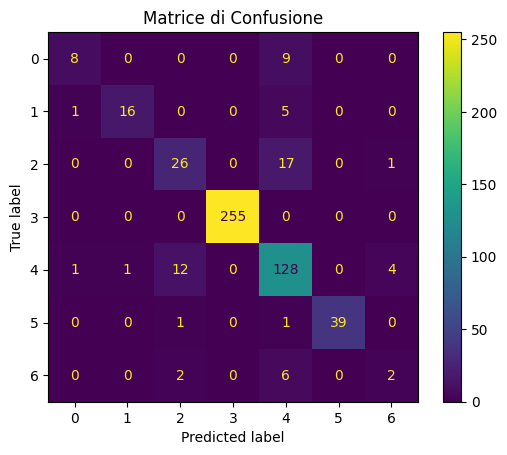

In [146]:
# Calcolo matrice di confusione
cm = confusion_matrix(y_validation_df1, y_val_pred)

# Visualizzazione matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model_1.classes_)
disp.plot(cmap='viridis')
plt.title("Matrice di Confusione")
plt.show()

La matrice di confusione mostra come le predizioni del modello si distribuiscono tra le classi. Si nota che alcune classi meno rappresentate (es., classe 6) vengono spesso confuse con altre classi, mentre le classi più popolose (es., classe 3) ottengono prestazioni migliori.

In [148]:
# Calcolo della accuratezza e valutazione del modello
val_accuracy_df1 = accuracy_score(y_validation_df1, y_val_pred)
print(f"Accuratezza sul set di validazione: {val_accuracy_df1:.3f}")

Accuratezza sul set di validazione: 0.886


In [142]:
# Calcolo macro e weighted metrics
report = classification_report(y_validation_df1, y_val_pred, output_dict=True)

print("\nMetriche Aggregate:")
print(f"Precisione macro: {report['macro avg']['precision']:.3f}")
print(f"Recall macro: {report['macro avg']['recall']:.3f}")
print(f"F1-score macro: {report['macro avg']['f1-score']:.3f}")

print(f"Precisione weighted: {report['weighted avg']['precision']:.3f}")
print(f"Recall weighted: {report['weighted avg']['recall']:.3f}")
print(f"F1-score weighted: {report['weighted avg']['f1-score']:.3f}")


Metriche Aggregate:
Precisione macro: 0.776
Recall macro: 0.688
F1-score macro: 0.722
Precisione weighted: 0.885
Recall weighted: 0.886
F1-score weighted: 0.883


* Le metriche macro evidenziano come il modello si comporta mediamente su tutte le classi, penalizzando maggiormente le classi con meno dati. Nel nostro caso, l'F1-score macro è inferiore (0.72) rispetto all'F1-score weighted (0.88), mostrando che il modello è meno efficace sulle classi meno rappresentate.
* Le metriche per la classe 6 mostrano un recall molto basso (20%), suggerendo difficoltà a identificare correttamente istanze di questa classe. Questo potrebbe essere affrontato migliorando il bilanciamento del dataset.

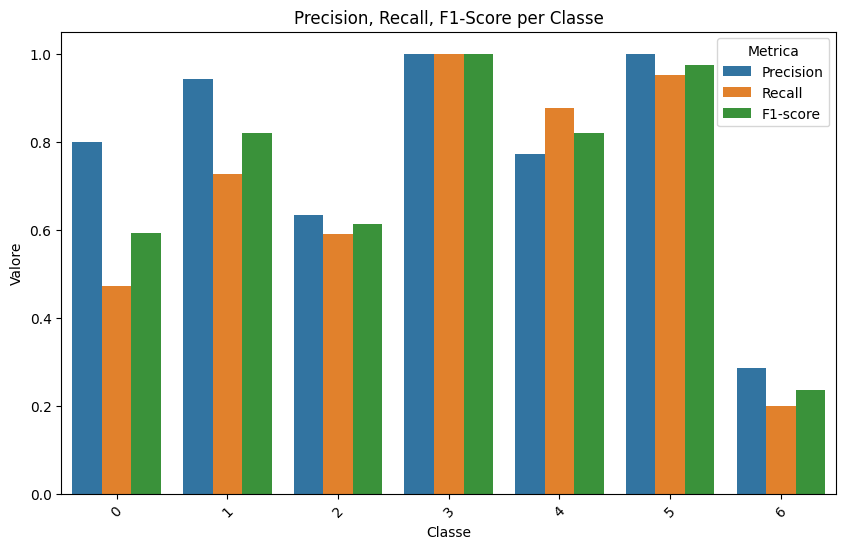

In [143]:
# Conversione del report in dataframe
classes = list(report.keys())[:-3]  # Esclude "accuracy", "macro avg" e "weighted avg"

precision = [report[cls]['precision'] for cls in classes]
recall = [report[cls]['recall'] for cls in classes]
f1_score = [report[cls]['f1-score'] for cls in classes]

# Creazione del DataFrame per il plot
metrics_df = pd.DataFrame({'Classi': classes, 'Precision': precision, 'Recall': recall, 'F1-score': f1_score})
metrics_df = metrics_df.melt(id_vars='Classi', var_name='Metrica', value_name='Valore')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Classi', y='Valore', hue='Metrica')
plt.title("Precision, Recall, F1-Score per Classe")
plt.ylabel("Valore")
plt.xlabel("Classe")
plt.xticks(rotation=45)
plt.legend(title="Metrica")
plt.show()


In [151]:
# Previsioni sul set di test
y_test_pred = svm_model_1.predict(X_test_df1)

# Calcolo della accuratezza e valutazione del modello
test_accuracy_df1 = accuracy_score(y_test_df1, y_test_pred)
print(f"Accuratezza sul set di test: {test_accuracy_df1:.3f}")

Accuratezza sul set di test: 0.886


In [152]:
report_test = classification_report(y_test_df1, y_test_pred, output_dict=True)

print("\nMetriche Aggregate:")
print(f"Precisione macro: {report_test['macro avg']['precision']:.3f}")
print(f"Recall macro: {report_test['macro avg']['recall']:.3f}")
print(f"F1-score macro: {report_test['macro avg']['f1-score']:.3f}")

print(f"Precisione weighted: {report_test['weighted avg']['precision']:.3f}")
print(f"Recall weighted: {report_test['weighted avg']['recall']:.3f}")
print(f"F1-score weighted: {report_test['weighted avg']['f1-score']:.3f}")


Metriche Aggregate:
Precisione macro: 0.764
Recall macro: 0.717
F1-score macro: 0.731
Precisione weighted: 0.880
Recall weighted: 0.886
F1-score weighted: 0.880


Le metriche sul test set sono simili a quelle del validation set -> il modello ha generalizzato bene.

#### df_2

In [147]:
# Definizione e training del modello SVM
svm_model_2 = SVC(kernel='linear', C=1, probability=True, random_state=42)

print("Training del modello SVM...")
svm_model_2.fit(X_train_df2, y_train_df2)

Training del modello SVM...


SVC(C=1, kernel='linear', probability=True, random_state=42)

In [153]:
# Previsioni sul set di validazione
y_val_pred_df2 = svm_model_2.predict(X_validation_df2)

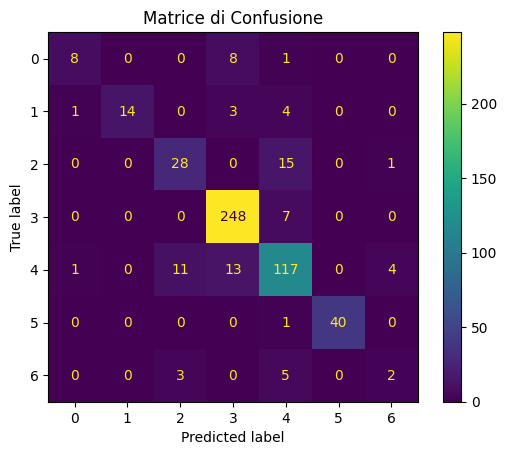

In [154]:
# Calcolo matrice di confusione
cm = confusion_matrix(y_validation_df2, y_val_pred_df2)

# Visualizzazione matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model_2.classes_)
disp.plot(cmap='viridis')
plt.title("Matrice di Confusione")
plt.show()

In [156]:
# Calcolo della accuratezza e valutazione del modello
val_accuracy_df2 = accuracy_score(y_validation_df2, y_val_pred_df2)
print(f"Accuratezza sul set di validazione: {val_accuracy_df2:.3f}")

Accuratezza sul set di validazione: 0.854


Il modello raggiunge un'accuratezza del 85.4%, ma essendo un dataset sbilanciato, questa metrica non è sufficiente a valutare le prestazioni del modello.

In [157]:
# Calcolo macro e weighted metrics
report_df2 = classification_report(y_validation_df2, y_val_pred_df2, output_dict=True)

print("\nMetriche Aggregate:")
print(f"Precisione macro: {report_df2['macro avg']['precision']:.3f}")
print(f"Recall macro: {report_df2['macro avg']['recall']:.3f}")
print(f"F1-score macro: {report_df2['macro avg']['f1-score']:.3f}")

print(f"Precisione weighted: {report_df2['weighted avg']['precision']:.3f}")
print(f"Recall weighted: {report_df2['weighted avg']['recall']:.3f}")
print(f"F1-score weighted: {report_df2['weighted avg']['f1-score']:.3f}")


Metriche Aggregate:
Precisione macro: 0.778
Recall macro: 0.670
F1-score macro: 0.711
Precisione weighted: 0.851
Recall weighted: 0.854
F1-score weighted: 0.849


* Classe 6 ha una recall molto bassa (0.20), indicando problemi nel riconoscere questa classe.
* Le classi 5 e 3 hanno prestazioni eccellenti (alta precisione e recall), mentre classe 0 ha un recall basso (0.47), evidenziando false negatività.
* Le metriche macro indicano buone prestazioni generali, ma penalizzano le classi meno rappresentate.
* Le metriche weighted evidenziano prestazioni solide nelle classi più grandi.

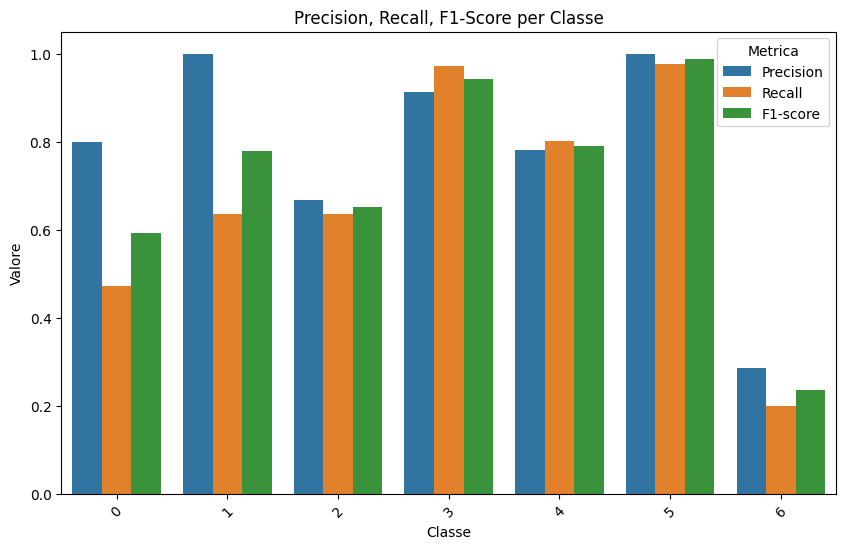

In [158]:
# Conversione del report in dataframe
classes = list(report_df2.keys())[:-3]  # Esclude "accuracy", "macro avg" e "weighted avg"

precision = [report_df2[cls]['precision'] for cls in classes]
recall = [report_df2[cls]['recall'] for cls in classes]
f1_score = [report_df2[cls]['f1-score'] for cls in classes]

# Creazione del DataFrame per il plot
metrics_df = pd.DataFrame({'Classi': classes, 'Precision': precision, 'Recall': recall, 'F1-score': f1_score})
metrics_df = metrics_df.melt(id_vars='Classi', var_name='Metrica', value_name='Valore')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Classi', y='Valore', hue='Metrica')
plt.title("Precision, Recall, F1-Score per Classe")
plt.ylabel("Valore")
plt.xlabel("Classe")
plt.xticks(rotation=45)
plt.legend(title="Metrica")
plt.show()

In [159]:
# Previsioni sul set di test
y_test_pred = svm_model_2.predict(X_test_df2)

# Calcolo della accuratezza e valutazione del modello
test_accuracy_df2 = accuracy_score(y_test_df2, y_test_pred)
print(f"Accuratezza sul set di test: {test_accuracy_df2:.3f}")

Accuratezza sul set di test: 0.858


In [160]:
report_test_df2 = classification_report(y_test_df2, y_test_pred, output_dict=True)

print("\nMetriche Aggregate:")
print(f"Precisione macro: {report_test_df2['macro avg']['precision']:.3f}")
print(f"Recall macro: {report_test_df2['macro avg']['recall']:.3f}")
print(f"F1-score macro: {report_test_df2['macro avg']['f1-score']:.3f}")

print(f"Precisione weighted: {report_test_df2['weighted avg']['precision']:.3f}")
print(f"Recall weighted: {report_test_df2['weighted avg']['recall']:.3f}")
print(f"F1-score weighted: {report_test_df2['weighted avg']['f1-score']:.3f}")


Metriche Aggregate:
Precisione macro: 0.758
Recall macro: 0.701
F1-score macro: 0.715
Precisione weighted: 0.848
Recall weighted: 0.858
F1-score weighted: 0.849


#### df_3

In [180]:
# Definizione e training del modello SVM
svm_model_3 = SVC(kernel='linear', C=1, probability=True, random_state=42)

print("Training del modello SVM...")
svm_model_3.fit(X_training_df3, y_train_df3)

Training del modello SVM...


SVC(C=4, kernel='linear', probability=True, random_state=42)

In [181]:
# Previsioni sul set di validazione
y_val_pred_df3 = svm_model_3.predict(X_validation_df3)

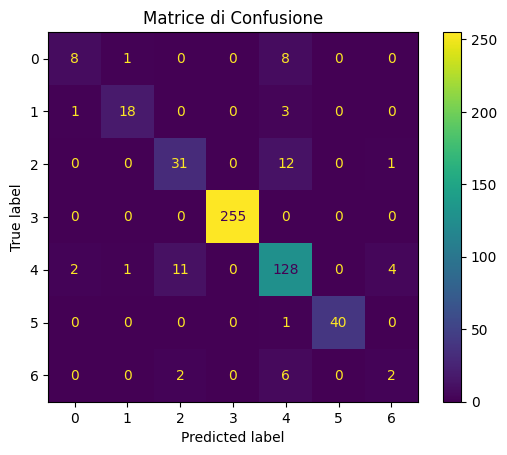

In [182]:
# Calcolo matrice di confusione
cm = confusion_matrix(y_validation_df3, y_val_pred_df3)

# Visualizzazione matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model_3.classes_)
disp.plot(cmap='viridis')
plt.title("Matrice di Confusione")
plt.show()

In [183]:
# Calcolo della accuratezza e valutazione del modello
val_accuracy_df3 = accuracy_score(y_validation_df3, y_val_pred_df3)
print(f"Accuratezza sul set di validazione: {val_accuracy_df3:.3f}")

Accuratezza sul set di validazione: 0.901


In [184]:
# Calcolo macro e weighted metrics
report_df3 = classification_report(y_validation_df3, y_val_pred_df3, output_dict=True)

print("\nMetriche Aggregate:")
print(f"Precisione macro: {report_df3['macro avg']['precision']:.3f}")
print(f"Recall macro: {report_df3['macro avg']['recall']:.3f}")
print(f"F1-score macro: {report_df3['macro avg']['f1-score']:.3f}")

print(f"Precisione weighted: {report_df3['weighted avg']['precision']:.3f}")
print(f"Recall weighted: {report_df3['weighted avg']['recall']:.3f}")
print(f"F1-score weighted: {report_df3['weighted avg']['f1-score']:.3f}")


Metriche Aggregate:
Precisione macro: 0.775
Recall macro: 0.721
F1-score macro: 0.743
Precisione weighted: 0.898
Recall weighted: 0.901
F1-score weighted: 0.898


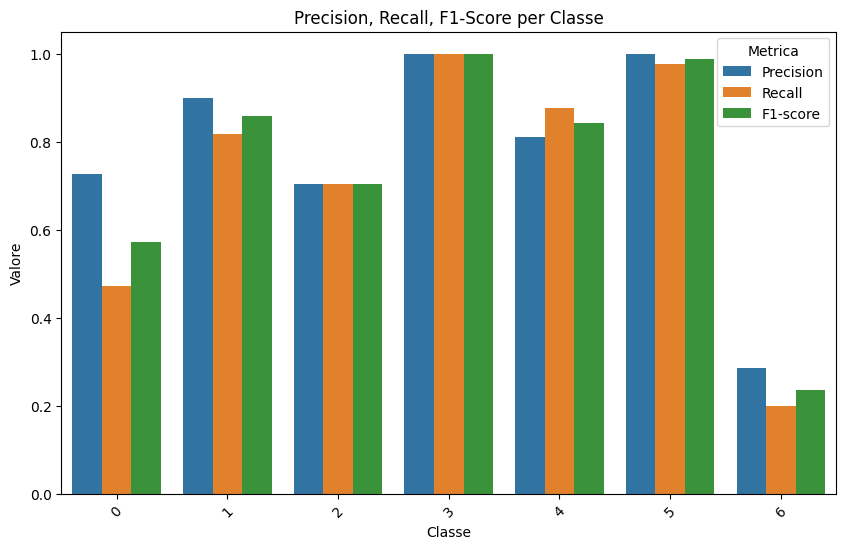

In [185]:
# Conversione del report in dataframe
classes = list(report_df3.keys())[:-3]  # Esclude "accuracy", "macro avg" e "weighted avg"

precision = [report_df3[cls]['precision'] for cls in classes]
recall = [report_df3[cls]['recall'] for cls in classes]
f1_score = [report_df3[cls]['f1-score'] for cls in classes]

# Creazione del DataFrame per il plot
metrics_df = pd.DataFrame({'Classi': classes, 'Precision': precision, 'Recall': recall, 'F1-score': f1_score})
metrics_df = metrics_df.melt(id_vars='Classi', var_name='Metrica', value_name='Valore')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Classi', y='Valore', hue='Metrica')
plt.title("Precision, Recall, F1-Score per Classe")
plt.ylabel("Valore")
plt.xlabel("Classe")
plt.xticks(rotation=45)
plt.legend(title="Metrica")
plt.show()

In [186]:
# Previsioni sul set di test
y_test_pred = svm_model_3.predict(X_test_df3)

# Calcolo della accuratezza e valutazione del modello
test_accuracy_df3 = accuracy_score(y_test_df3, y_test_pred)
print(f"Accuratezza sul set di test: {test_accuracy_df3:.3f}")

Accuratezza sul set di test: 0.888


In [187]:
report_test_df3 = classification_report(y_test_df3, y_test_pred, output_dict=True)

print("\nMetriche Aggregate:")
print(f"Precisione macro: {report_test_df3['macro avg']['precision']:.3f}")
print(f"Recall macro: {report_test_df3['macro avg']['recall']:.3f}")
print(f"F1-score macro: {report_test_df3['macro avg']['f1-score']:.3f}")

print(f"Precisione weighted: {report_test_df3['weighted avg']['precision']:.3f}")
print(f"Recall weighted: {report_test_df3['weighted avg']['recall']:.3f}")
print(f"F1-score weighted: {report_test_df3['weighted avg']['f1-score']:.3f}")


Metriche Aggregate:
Precisione macro: 0.753
Recall macro: 0.745
F1-score macro: 0.741
Precisione weighted: 0.879
Recall weighted: 0.888
F1-score weighted: 0.882


#### Considerazioni

* df_1 (dataset sporco): 0.886 di accuratezza
* df_2 (dataset pulito, solo feature testuali): 0.858 di accuratezza
* df_3 (dataset pulito, tutte le feature): 0.888 di accuratezza


**Analisi**:

* L'accuratezza su df_1 è superiore rispetto a quella su df_2, indicando che SVM riesce a gestire bene anche un dataset con dati incompleti o incoerenti. Questo potrebbe essere dovuto alla capacità di SVM di trovare margini ottimali e fare delle generalizzazioni migliori anche su dati meno puliti.
* **df_1**: Il dataset di baseline (prima della pulizia) è già molto buono, con un buon livello di accuratezza. Le performance sono stabili grazie alla varietà di feature. Il modello dà buoni risultati nelle classi maggiori, ma le metriche macro indicano un lieve squilibrio nelle prestazioni tra le classi.
* **df_2**: L'accuratezza inferiore indica un calo nelle prestazioni dovuto alla rimozione di molte feature. Le metriche macro e ponderate sono leggermente peggiorate, il che suggerisce che l'aggiunta di altre caratteristiche è essenziale per migliorare il modello.
* **df_3**: L'accuratezza migliora grazie al miglioramento della qualità dei dati. La pulizia e il preprocessing hanno sicuramente avuto un impatto positivo, e le metriche weighted evidenziano prestazioni superiori per le classi più piccole. Questo dataset rappresenta il modello più robusto e ben generalizzato.

Il miglioramento tra DF1 e DF3 evidenzia l'importanza di pulire e preprocessare i dati prima dell'addestramento.

### Decision Tree Classifier

Gli **alberi decisionali** sono modelli di apprendimento automatico utilizzati sia per problemi di classificazione che di regressione. Operano dividendo ripetutamente il dataset in sottoinsiemi omogenei in base alle caratteristiche dei dati, fino a quando non viene raggiunta una condizione di stop predefinita. Due caratteristiche principali degli alberi decisionali sono:

1. Interpretabilità: Gli alberi decisionali sono modelli facilmente interpretabili, poiché le regole di decisione sono rappresentate sotto forma di albero. Questo permette di comprendere facilmente il processo decisionale seguito dal modello.

1. Versatilità: Gli alberi decisionali possono gestire sia dati numerici che categorici e possono essere utilizzati per risolvere una vasta gamma di problemi di machine learning. Possono anche essere combinati con tecniche come il pruning per evitare l'overfitting e migliorare le prestazioni del modello.

Gli alberi di decisione possono gestire variabili categoriche, ma è preferibile convertire le variabili categoriche in variabili numeriche o booleane per garantire una migliore compatibilità con l'algoritmo e per ottenere risultati più significativi.

#### df_1

In [190]:
# Definizione e training del modello Decision Tree
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)

print("Training del modello Decision Tree...")
dt_model.fit(X_training_df1, y_train_df1)

Training del modello Decision Tree...


DecisionTreeClassifier(random_state=42)

In [207]:
# Previsioni sul set di validazione
y_val_pred = dt_model.predict(X_validation_df1)

# Calcolo della precisione e valutazione del modello
val_accuracy = accuracy_score(y_validation_df1, y_val_pred)
print(f"Accuratezza sul set di validazione: {val_accuracy:.3f}")

print("\nReport di classificazione sul set di validazione:")
print(classification_report(y_validation_df1, y_val_pred))


Accuratezza sul set di validazione: 0.852

Report di classificazione sul set di validazione:
              precision    recall  f1-score   support

           0       0.53      0.47      0.50        17
           1       0.73      0.73      0.73        22
           2       0.58      0.48      0.53        44
           3       1.00      1.00      1.00       255
           4       0.75      0.81      0.78       146
           5       0.97      0.83      0.89        41
           6       0.27      0.40      0.32        10

    accuracy                           0.85       535
   macro avg       0.69      0.67      0.68       535
weighted avg       0.86      0.85      0.85       535



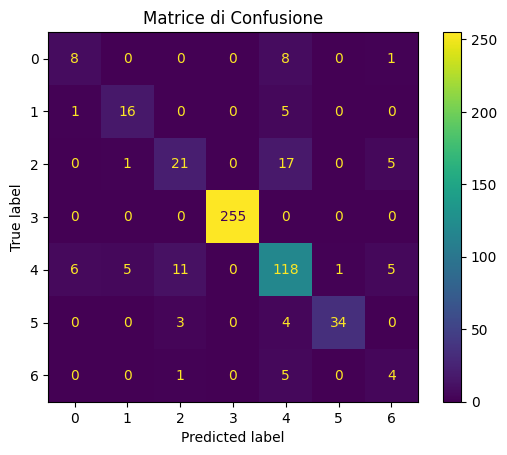

In [215]:
# Calcolo matrice di confusione
cm = confusion_matrix(y_validation_df1, y_val_pred)

# Visualizzazione matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot(cmap='viridis')
plt.title("Matrice di Confusione")
plt.show()

In [194]:
# Previsioni sul set di test
y_test_pred = dt_model.predict(X_test_df1)
test_accuracy = accuracy_score(y_test_df1, y_test_pred)

print(f"\nAccuratezza sul set di test: {test_accuracy:.3f}")
print("Report di classificazione sul set di test:")
print(classification_report(y_test_df1, y_test_pred))


Accuratezza sul set di test: 0.869
Report di classificazione sul set di test:
              precision    recall  f1-score   support

           0       0.70      0.89      0.78        18
           1       0.67      0.74      0.70        19
           2       0.62      0.57      0.59        37
           3       1.00      1.00      1.00       268
           4       0.79      0.79      0.79       137
           5       0.90      0.90      0.90        40
           6       0.23      0.18      0.20        17

    accuracy                           0.87       536
   macro avg       0.70      0.72      0.71       536
weighted avg       0.87      0.87      0.87       536



In [195]:
report_test = classification_report(y_test_df1, y_test_pred, output_dict=True)

print("\nMetriche Aggregate:")
print(f"Precisione macro: {report_test['macro avg']['precision']:.3f}")
print(f"Recall macro: {report_test['macro avg']['recall']:.3f}")
print(f"F1-score macro: {report_test['macro avg']['f1-score']:.3f}")

print(f"Precisione weighted: {report_test['weighted avg']['precision']:.3f}")
print(f"Recall weighted: {report_test['weighted avg']['recall']:.3f}")
print(f"F1-score weighted: {report_test['weighted avg']['f1-score']:.3f}")


Metriche Aggregate:
Precisione macro: 0.700
Recall macro: 0.723
F1-score macro: 0.709
Precisione weighted: 0.866
Recall weighted: 0.869
F1-score weighted: 0.867


#### df_2

In [196]:
# Definizione e training del modello Decision Tree
dt_model_df2 = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)

print("Training del modello Decision Tree (df2)...")
dt_model_df2.fit(X_train_df2, y_train_df2)

Training del modello Decision Tree (df2)...


DecisionTreeClassifier(random_state=42)

In [197]:
# Previsioni sul set di validazione
y_val_pred_df2 = dt_model_df2.predict(X_validation_df2)

# Calcolo della precisione e valutazione del modello
val_accuracy_df2 = accuracy_score(y_validation_df2, y_val_pred_df2)
print(f"Accuratezza sul set di validazione (df2): {val_accuracy_df2:.3f}")

print("\nReport di classificazione sul set di validazione (df2):")
print(classification_report(y_validation_df2, y_val_pred_df2))

Accuratezza sul set di validazione (df2): 0.770

Report di classificazione sul set di validazione (df2):
              precision    recall  f1-score   support

           0       0.54      0.41      0.47        17
           1       0.83      0.68      0.75        22
           2       0.48      0.50      0.49        44
           3       0.88      0.91      0.90       255
           4       0.66      0.66      0.66       146
           5       0.97      0.88      0.92        41
           6       0.22      0.20      0.21        10

    accuracy                           0.77       535
   macro avg       0.65      0.61      0.63       535
weighted avg       0.77      0.77      0.77       535



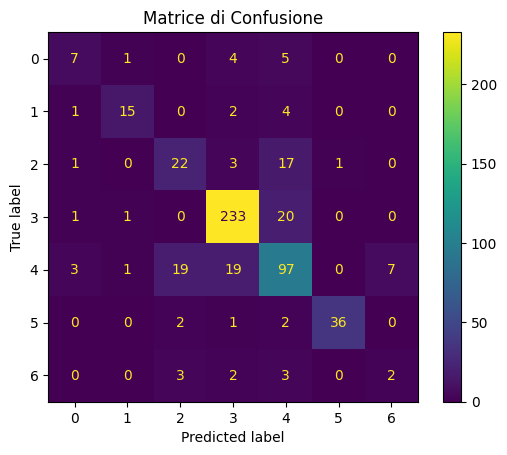

In [198]:
# Calcolo matrice di confusione
cm = confusion_matrix(y_validation_df2, y_val_pred_df2)

# Visualizzazione matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model_df2.classes_)
disp.plot(cmap='viridis')
plt.title("Matrice di Confusione")
plt.show()

In [199]:
# Previsioni sul set di test
y_test_pred_df2 = dt_model_df2.predict(X_test_df2)
test_accuracy_df2 = accuracy_score(y_test_df2, y_test_pred_df2)

print(f"\nAccuratezza sul set di test (df2): {test_accuracy_df2:.3f}")
print("Report di classificazione sul set di test (df2):")
print(classification_report(y_test_df2, y_test_pred_df2))


Accuratezza sul set di test (df2): 0.780
Report di classificazione sul set di test (df2):
              precision    recall  f1-score   support

           0       0.79      0.61      0.69        18
           1       0.58      0.58      0.58        19
           2       0.40      0.51      0.45        37
           3       0.89      0.92      0.91       268
           4       0.67      0.66      0.67       137
           5       0.95      0.93      0.94        40
           6       0.50      0.18      0.26        17

    accuracy                           0.78       536
   macro avg       0.68      0.63      0.64       536
weighted avg       0.78      0.78      0.78       536



In [200]:
report_test_df2 = classification_report(y_test_df2, y_test_pred_df2, output_dict=True)

print("\nMetriche Aggregate:")
print(f"Precisione macro: {report_test_df2['macro avg']['precision']:.3f}")
print(f"Recall macro: {report_test_df2['macro avg']['recall']:.3f}")
print(f"F1-score macro: {report_test_df2['macro avg']['f1-score']:.3f}")

print(f"Precisione weighted: {report_test_df2['weighted avg']['precision']:.3f}")
print(f"Recall weighted: {report_test_df2['weighted avg']['recall']:.3f}")
print(f"F1-score weighted: {report_test_df2['weighted avg']['f1-score']:.3f}")


Metriche Aggregate:
Precisione macro: 0.683
Recall macro: 0.627
F1-score macro: 0.641
Precisione weighted: 0.780
Recall weighted: 0.780
F1-score weighted: 0.777


#### df_3

In [201]:
# Definizione e training del modello Decision Tree
dt_model_df3 = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)

print("Training del modello Decision Tree (df_3)...")
dt_model_df3.fit(X_training_df3, y_train_df3)

Training del modello Decision Tree (df_3)...


DecisionTreeClassifier(random_state=42)

In [202]:
# Previsioni sul set di validazione
y_val_pred_df3 = dt_model_df3.predict(X_validation_df3)

# Calcolo della precisione e valutazione del modello
val_accuracy_df3 = accuracy_score(y_validation_df3, y_val_pred_df3)
print(f"Accuratezza sul set di validazione (df_3): {val_accuracy_df3:.3f}")

print("\nReport di classificazione sul set di validazione (df_3):")
print(classification_report(y_validation_df3, y_val_pred_df3))

Accuratezza sul set di validazione (df_3): 0.860

Report di classificazione sul set di validazione (df_3):
              precision    recall  f1-score   support

           0       0.80      0.47      0.59        17
           1       0.60      0.82      0.69        22
           2       0.58      0.57      0.57        44
           3       1.00      1.00      1.00       255
           4       0.79      0.79      0.79       146
           5       1.00      0.85      0.92        41
           6       0.20      0.30      0.24        10

    accuracy                           0.86       535
   macro avg       0.71      0.69      0.69       535
weighted avg       0.87      0.86      0.86       535



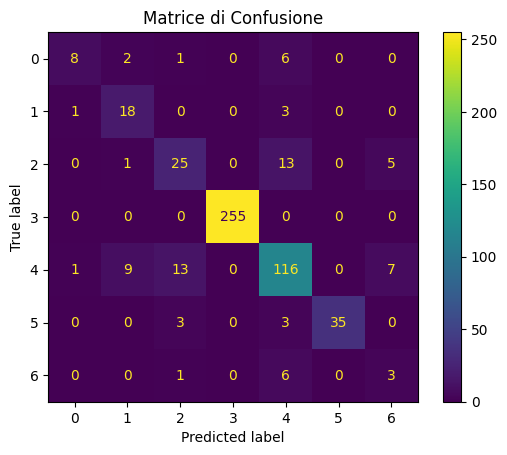

In [204]:
# Calcolo matrice di confusione
cm = confusion_matrix(y_validation_df3, y_val_pred_df3)

# Visualizzazione matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model_df3.classes_)
disp.plot(cmap='viridis')
plt.title("Matrice di Confusione")
plt.show()

In [203]:
# Previsioni sul set di test
y_test_pred_df3 = dt_model_df3.predict(X_test_df3)
test_accuracy_df3 = accuracy_score(y_test_df3, y_test_pred_df3)

print(f"\nAccuratezza sul set di test (df_3): {test_accuracy_df3:.3f}")
print("Report di classificazione sul set di test (df_3):")
print(classification_report(y_test_df3, y_test_pred_df3))


Accuratezza sul set di test (df_3): 0.882
Report di classificazione sul set di test (df_3):
              precision    recall  f1-score   support

           0       0.76      0.89      0.82        18
           1       0.64      0.84      0.73        19
           2       0.68      0.57      0.62        37
           3       1.00      1.00      1.00       268
           4       0.82      0.80      0.81       137
           5       0.95      0.88      0.91        40
           6       0.38      0.47      0.42        17

    accuracy                           0.88       536
   macro avg       0.75      0.78      0.76       536
weighted avg       0.89      0.88      0.88       536



In [205]:
report_test_df3 = classification_report(y_test_df3, y_test_pred, output_dict=True)

print("\nMetriche Aggregate:")
print(f"Precisione macro: {report_test_df3['macro avg']['precision']:.3f}")
print(f"Recall macro: {report_test_df3['macro avg']['recall']:.3f}")
print(f"F1-score macro: {report_test_df3['macro avg']['f1-score']:.3f}")

print(f"Precisione weighted: {report_test_df3['weighted avg']['precision']:.3f}")
print(f"Recall weighted: {report_test_df3['weighted avg']['recall']:.3f}")
print(f"F1-score weighted: {report_test_df3['weighted avg']['f1-score']:.3f}")


Metriche Aggregate:
Precisione macro: 0.700
Recall macro: 0.723
F1-score macro: 0.709
Precisione weighted: 0.866
Recall weighted: 0.869
F1-score weighted: 0.867


#### Considerazioni

* df_1 (dataset sporco): 0.869
* df_2 (dataset pulito, solo feature testuali): 0.780
* df_3 (dataset pulito, tutte le feature): 0.882


**Analisi**:

I risultati mostrano che Decision Tree fatica di più rispetto agli altri classificatori con i dati puliti e solo testuali (df_2), probabilmente perché l'albero decisionale tende a soffrire di overfitting quando viene addestrato su un numero elevato di feature non informativi, o potrebbe non essere in grado di gestire correttamente le feature testuali.
Il modello recupera quando tutte le feature sono disponibili (su df_3), suggerendo che l'integrazione delle feature numeriche aiuta il classificatore a costruire alberi decisionali migliori e a generalizzare meglio rispetto ai dati solo testuali. Inoltre, potrebbe trarre vantaggio dall'inclusione di feature categoriche.

### Random Forest

Abbiamo scelto di utilizzare il modello **Random Forest** per la classificazione poiché è un metodo di ensemble learning che combina più alberi decisionali per migliorare le previsioni e ridurre il rischio di overfitting. Questo modello è efficace nel gestire grandi quantità di dati con variabili numeriche e categoriche, ed è robusto nel trattare dati complessi e non lineari. A differenza di singoli alberi decisionali, Random Forest gestisce meglio la varianza e gli errori dovuti a sovradattamento. Inoltre, non richiede un'accurata pre-elaborazione dei dati, come la normalizzazione. Per queste ragioni, Random Forest è una scelta adatta per problemi di classificazione con dati reali, come il nostro.

#### df_1

In [279]:
# Definizione e training del modello Random Forest (df1)
rf_model_df1 = RandomForestClassifier(n_estimators=100, random_state=42)

print("Training del modello Random Forest (df1)...")
rf_model_df1.fit(X_training_df1, y_train_df1)

Training del modello Random Forest (df1)...


RandomForestClassifier(random_state=42)

In [277]:
# Previsioni sul set di validazione
y_val_pred_df1 = rf_model_df1.predict(X_validation_df1)

# Calcolo della precisione e valutazione del modello
val_accuracy_df1 = accuracy_score(y_validation_df1, y_val_pred_df1)
print(f"Accuratezza sul set di validazione (df1): {val_accuracy_df1:.3f}")

print("\nReport di classificazione sul set di validazione (df1):")
print(classification_report(y_validation_df1, y_val_pred_df1))

Accuratezza sul set di validazione (df1): 0.804

Report di classificazione sul set di validazione (df1):
              precision    recall  f1-score   support

           0       0.60      0.35      0.44        17
           1       0.57      0.73      0.64        22
           2       0.50      0.59      0.54        44
           3       0.99      0.96      0.98       255
           4       0.71      0.69      0.70       146
           5       0.75      0.73      0.74        41
           6       0.36      0.50      0.42        10

    accuracy                           0.80       535
   macro avg       0.64      0.65      0.64       535
weighted avg       0.81      0.80      0.81       535



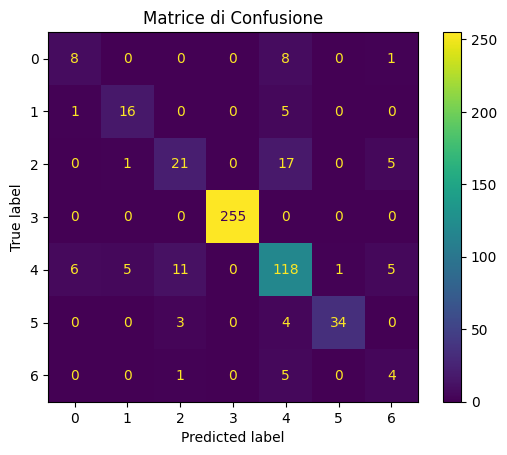

In [278]:
# Calcolo matrice di confusione
cm = confusion_matrix(y_validation_df1, y_val_pred)

# Visualizzazione matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model_df1.classes_)
disp.plot(cmap='viridis')
plt.title("Matrice di Confusione")
plt.show()

In [267]:
# Previsioni sul set di test
y_test_pred_df1 = rf_model_df1.predict(X_test_df1)
test_accuracy_df1 = accuracy_score(y_test_df1, y_test_pred_df1)

print(f"\nAccuratezza sul set di test (df1): {test_accuracy_df1:.3f}")
print("Report di classificazione sul set di test (df1):")
print(classification_report(y_test_df1, y_test_pred_df1))


Accuratezza sul set di test (df1): 0.800
Report di classificazione sul set di test (df1):
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        18
           1       0.46      0.58      0.51        19
           2       0.45      0.57      0.50        37
           3       1.00      0.97      0.98       268
           4       0.67      0.67      0.67       137
           5       0.88      0.72      0.79        40
           6       0.06      0.06      0.06        17

    accuracy                           0.80       536
   macro avg       0.62      0.63      0.62       536
weighted avg       0.81      0.80      0.80       536



In [223]:
report_test = classification_report(y_test_df1, y_test_pred, output_dict=True)

print("\nMetriche Aggregate:")
print(f"Precisione macro: {report_test['macro avg']['precision']:.3f}")
print(f"Recall macro: {report_test['macro avg']['recall']:.3f}")
print(f"F1-score macro: {report_test['macro avg']['f1-score']:.3f}")

print(f"Precisione weighted: {report_test['weighted avg']['precision']:.3f}")
print(f"Recall weighted: {report_test['weighted avg']['recall']:.3f}")
print(f"F1-score weighted: {report_test['weighted avg']['f1-score']:.3f}")


Metriche Aggregate:
Precisione macro: 0.700
Recall macro: 0.723
F1-score macro: 0.709
Precisione weighted: 0.866
Recall weighted: 0.869
F1-score weighted: 0.867


#### df_2

In [274]:
# Definizione e training del modello Random Forest (df2)
rf_model_df2 = RandomForestClassifier(n_estimators=100, random_state=42)

print("Training del modello Random Forest (df2)...")
rf_model_df2.fit(X_train_df2, y_train_df2)

Training del modello Random Forest (df2)...


RandomForestClassifier(random_state=42)

In [270]:
# Previsioni sul set di validazione
y_val_pred_df2 = rf_model_df2.predict(X_validation_df2)

# Calcolo della precisione e valutazione del modello
val_accuracy_df2 = accuracy_score(y_validation_df2, y_val_pred_df2)
print(f"Accuratezza sul set di validazione (df2): {val_accuracy_df2:.3f}")

print("\nReport di classificazione sul set di validazione (df2):")
print(classification_report(y_validation_df2, y_val_pred_df2))

Accuratezza sul set di validazione (df2): 0.770

Report di classificazione sul set di validazione (df2):
              precision    recall  f1-score   support

           0       0.47      0.41      0.44        17
           1       0.93      0.59      0.72        22
           2       0.58      0.48      0.53        44
           3       0.86      0.92      0.89       255
           4       0.67      0.68      0.68       146
           5       0.90      0.85      0.88        41
           6       0.12      0.10      0.11        10

    accuracy                           0.77       535
   macro avg       0.65      0.58      0.61       535
weighted avg       0.76      0.77      0.76       535



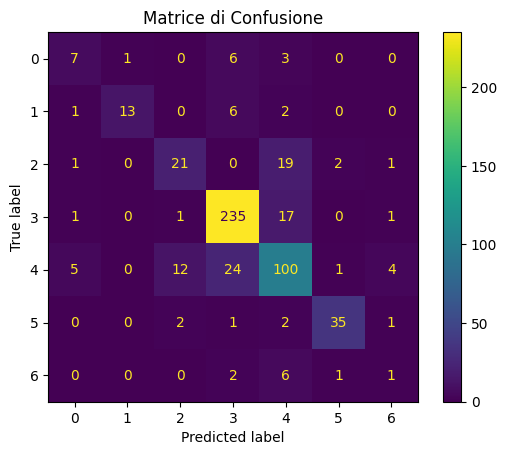

In [271]:
# Calcolo matrice di confusione
cm = confusion_matrix(y_validation_df2, y_val_pred_df2)

# Visualizzazione matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model_df2.classes_)
disp.plot(cmap='viridis')
plt.title("Matrice di Confusione")
plt.show()

In [272]:
# Previsioni sul set di test
y_test_pred_df2 = rf_model_df2.predict(X_test_df2)
test_accuracy_df2 = accuracy_score(y_test_df2, y_test_pred_df2)

print(f"\nAccuratezza sul set di test (df2): {test_accuracy_df2:.3f}")
print("Report di classificazione sul set di test (df2):")
print(classification_report(y_test_df2, y_test_pred_df2))



Accuratezza sul set di test (df2): 0.780
Report di classificazione sul set di test (df2):
              precision    recall  f1-score   support

           0       0.55      0.61      0.58        18
           1       0.59      0.53      0.56        19
           2       0.45      0.46      0.45        37
           3       0.88      0.92      0.90       268
           4       0.72      0.68      0.70       137
           5       0.93      0.93      0.93        40
           6       0.27      0.18      0.21        17

    accuracy                           0.78       536
   macro avg       0.63      0.61      0.62       536
weighted avg       0.77      0.78      0.78       536



In [273]:
report_test_df2 = classification_report(y_test_df2, y_test_pred_df2, output_dict=True)

print("\nMetriche Aggregate:")
print(f"Precisione macro: {report_test_df2['macro avg']['precision']:.3f}")
print(f"Recall macro: {report_test_df2['macro avg']['recall']:.3f}")
print(f"F1-score macro: {report_test_df2['macro avg']['f1-score']:.3f}")

print(f"Precisione weighted: {report_test_df2['weighted avg']['precision']:.3f}")
print(f"Recall weighted: {report_test_df2['weighted avg']['recall']:.3f}")
print(f"F1-score weighted: {report_test_df2['weighted avg']['f1-score']:.3f}")


Metriche Aggregate:
Precisione macro: 0.626
Recall macro: 0.614
F1-score macro: 0.618
Precisione weighted: 0.772
Recall weighted: 0.780
F1-score weighted: 0.775


#### df_3

In [258]:
# Definizione e training del modello Random Forest (df3)
rf_model_df3 = RandomForestClassifier(n_estimators=100, random_state=42)

print("Training del modello Random Forest (df3)...")
rf_model_df3.fit(X_training_df3, y_train_df3)

Training del modello Random Forest (df3)...


RandomForestClassifier(random_state=42)

In [259]:
# Previsioni sul set di validazione
y_val_pred_df3 = rf_model_df3.predict(X_validation_df3)

# Calcolo della precisione e valutazione del modello
val_accuracy_df3 = accuracy_score(y_validation_df3, y_val_pred_df3)
print(f"Accuratezza sul set di validazione (df3): {val_accuracy_df3:.3f}")

print("\nReport di classificazione sul set di validazione (df3):")
print(classification_report(y_validation_df3, y_val_pred_df3))

Accuratezza sul set di validazione (df3): 0.882

Report di classificazione sul set di validazione (df3):
              precision    recall  f1-score   support

           0       0.80      0.47      0.59        17
           1       0.94      0.68      0.79        22
           2       0.62      0.57      0.60        44
           3       1.00      1.00      1.00       255
           4       0.76      0.90      0.82       146
           5       1.00      0.90      0.95        41
           6       0.25      0.10      0.14        10

    accuracy                           0.88       535
   macro avg       0.77      0.66      0.70       535
weighted avg       0.88      0.88      0.88       535



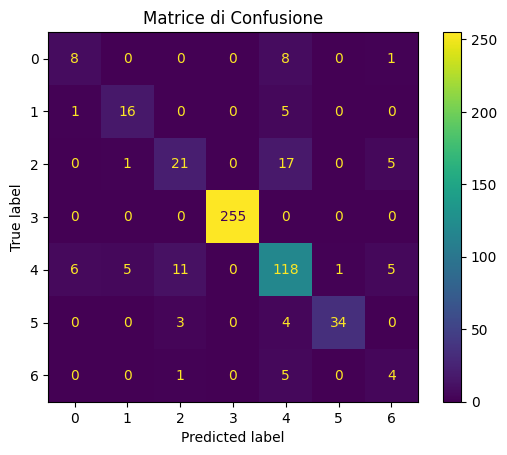

In [251]:
# Calcolo matrice di confusione
cm = confusion_matrix(y_validation_df3, y_val_pred_df3)

# Visualizzazione matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model_df3.classes_)
disp.plot(cmap='viridis')
plt.title("Matrice di Confusione")
plt.show()

In [257]:
# Previsioni sul set di test
y_test_pred_df3 = rf_model_df3.predict(X_test_df3)
test_accuracy_df3 = accuracy_score(y_test_df3, y_test_pred_df3)

print(f"\nAccuratezza sul set di test (df3): {test_accuracy_df3:.3f}")
print("Report di classificazione sul set di test (df3):")
print(classification_report(y_test_df3, y_test_pred_df3))


Accuratezza sul set di test (df3): 0.890
Report di classificazione sul set di test (df3):
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        18
           1       0.88      0.74      0.80        19
           2       0.57      0.62      0.60        37
           3       1.00      1.00      1.00       268
           4       0.79      0.88      0.83       137
           5       0.97      0.90      0.94        40
           6       0.00      0.00      0.00        17

    accuracy                           0.89       536
   macro avg       0.72      0.71      0.71       536
weighted avg       0.87      0.89      0.88       536



#### Considerazioni

* df_1 (dataset sporco): 0.879
* df_2 (dataset pulito, solo feature testuali): 0.834
* df_3 (dataset pulito, tutte le feature): 0.892


**Analisi**:

Come previsto, Random Forest performa meglio con il dataset df_3 che contiene tutte le feature. Questo perché RF è un classificatore più robusto rispetto a Decision Tree e può sfruttare meglio le informazioni fornite dalle feature numeriche e categoriali, evitando l'overfitting grazie alla combinazione di più alberi decisionali.
Sebbene df_1 abbia prestazioni relativamente alte (0.879), l'aggiunta di feature nel dataset pulito aumenta ulteriormente l'accuratezza, dimostrando l'importanza della qualità dei dati (pre-elaborazione) e la capacità del modello di beneficiare dell'accesso a una varietà di informazioni.

## Considerazioni Finali

**Miglioramenti con la pulizia dei dati:**
* I risultati confermano che un dataset pulito contribuisce notevolmente al miglioramento delle prestazioni, ma ci sono differenze evidenti nei tre modelli. I classificatori basati su alberi (Decision Tree e Random Forest) vedono un miglioramento consistente passando da df_1 a df_3, indicando che questi algoritmi traggono beneficio dal maggior numero di feature. La pulizia dei dati appare fondamentale per migliorare la qualità dei modelli.
* Al contrario, l'SVM mostra una performance meno influenzata dalla presenza di feature aggiuntive nel dataset, suggerendo che potrebbe esserci una saturazione nell'aggiungere informazioni extra a un modello che già gestisce bene i dati con meno feature.

**Adattabilità dei modelli:**

* SVM sembra robusto anche sui dati sporchi, probabilmente grazie alla sua capacità di gestire separazioni non lineari con margini di errore controllati.
* Decision Tree tende a soffrire in presenza di un grande numero di feature e, come osservato, il miglioramento maggiore si registra quando vengono aggiunte tutte le feature in df_3, dove probabilmente l'albero riesce a evitare il rischio di overfitting grazie a una base di dati più ricca.
* Random Forest mostra una solida performance in tutti i casi, dimostrando una maggiore robustezza nell'adattarsi a dati di qualità inferiore e nella gestione delle feature multiple.

I dati puliti e con feature complete consentono ai classificatori, in particolare a Decision Tree e Random Forest, di esprimere al meglio il loro potenziale. 